In [1]:
import strawberryfields as sf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# --- CONFIGURATION ---
sf.hbar = 1
np.random.seed(42)

# Parameters

eta, delta = 0.9, 0.01
num_steps = 300
learning_rate = 0.0005  
quad_pts = 200
quad_axis = np.linspace(-6, 6, quad_pts)
mu = np.random.uniform(0, 2*np.pi)

# --- Helper Functions ---
def db_to_epsilon(db_val: float) -> float:
    """
    Convert a given GKP squeezing level in dB to epsilon via:
         tanh(epsilon) = 10^(-db_val/10)
    """
    t = 10.0 ** (-db_val / 10.0)
    eps = 0.5 * np.log((1.0 + t) / (1.0 - t))
    return eps

def prepare_gkp_state(epsilon, eta, gamma, phi=0.0, Nphi=15, phi_clip=3.0):
    """
    Prepare GKP state under loss (eta) and approximate dephasing (gamma),
    returning its 2D Wigner function on the grid 'quad_axis'.
    """
    prog = sf.Program(1)
    eng = sf.Engine("bosonic")

    phi_std = np.sqrt(gamma)
    if gamma < 1e-12:
        with prog.context as q:
            sf.ops.GKP(state=[0,0], epsilon=epsilon) | q[0]
            if eta < 1.0:
                sf.ops.LossChannel(eta) | q[0]
            sf.ops.Rgate(phi) | q[0]
        state = eng.run(prog).state
        W = state.wigner(0, quad_axis, quad_axis)
        return W

    # Otherwise, approximate dephasing by averaging over random rotations
    phis = np.linspace(-phi_clip*phi_std, phi_clip*phi_std, Nphi)
    dphi = phis[1] - phis[0]
    weights = np.exp(-0.5*(phis/phi_std)**2)
    weights /= weights.sum()

    wigner_avg = np.zeros((quad_pts, quad_pts), dtype=float)
    for phi_val, w in zip(phis, weights):
        prog = sf.Program(1)
        with prog.context as q:
            sf.ops.GKP(state=[0,0], epsilon=epsilon) | q[0]
            sf.ops.LossChannel(eta) | q[0]
            sf.ops.Rgate(phi_val) | q[0]
        state = eng.run(prog).state
        wigner_avg += w * state.wigner(0, quad_axis, quad_axis)

    return wigner_avg

def marginal_from_wigner(W, xvec, phi):
    """
    Numerically compute the marginal distribution P(x_mu).
    = ∫ W(q,p) delta[x_mu - (q*cos(phi)+p*sin(phi))] dq dp.

    'Bin and accumulate' approach:
      - rotate each (q,p) -> x_mu
      - bin into xvec
      - sum W(q,p)*dq*dp
      - normalize
    """
    Q, P = np.meshgrid(xvec, xvec, indexing='xy')
    dq = xvec[1] - xvec[0]
    dp = dq

    X = Q * np.cos(phi) + P * np.sin(phi)

    P_x = np.zeros_like(xvec, dtype=float)
    for i in range(len(xvec)):
        for j in range(len(xvec)):
            xval = X[i,j]
            idx = int(np.floor((xval - xvec[0]) / dq))
            if 0 <= idx < len(xvec):
                P_x[idx] += W[i,j] * dq * dp

    # Normalize
    norm = np.trapz(P_x, xvec)
    if norm > 1e-15:
        P_x /= norm
    return P_x

def classical_fisher(mu, epsilon, eta, delta, d_eta=1e-3, d_delta=1e-3):
    """
    Calculate the 2x2 classical Fisher information matrix w.r.t. (eta, delta),
    given the homodyne measurement of quadrature x_mu.
    """
    # Base Wigner
    W_base = prepare_gkp_state(epsilon, eta, delta)
    P_mu = marginal_from_wigner(W_base, quad_axis, mu) + 1e-12

    # dP/d_eta
    W_eta_plus = prepare_gkp_state(epsilon, eta + d_eta, delta)
    P_eta_plus = marginal_from_wigner(W_eta_plus, quad_axis, mu) + 1e-12
    dP_eta = (P_eta_plus - P_mu) / d_eta

    # dP/d_delta
    W_delta_plus = prepare_gkp_state(epsilon, eta, delta + d_delta)
    P_delta_plus = marginal_from_wigner(W_delta_plus, quad_axis, mu) + 1e-12
    dP_delta = (P_delta_plus - P_mu) / d_delta

    # Fisher matrix
    F_eta_eta = np.trapz((dP_eta**2) / P_mu, quad_axis)
    F_delta_delta = np.trapz((dP_delta**2) / P_mu, quad_axis)
    F_eta_delta = np.trapz((dP_eta * dP_delta) / P_mu, quad_axis)

    return np.array([[F_eta_eta, F_eta_delta],
                     [F_eta_delta, F_delta_delta]])

def fisher_det_mu(mu, epsilon, eta, delta):
    """To return det(F) for given mu."""
    F = classical_fisher(mu, epsilon, eta, delta)
    return np.linalg.det(F)


c:\Users\tvle2\AppData\Local\anaconda3\envs\cv_Computing\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


### CFI 10 Db

In [2]:
epsilon = 0.1  # ~10 dB squeezing
print(f"Initial mu: {mu:.4f}")

fisher_history, mu_history = [], []
momentum = 0.9
velocity = 0

for step in tqdm(range(num_steps)):
    # Evaluate F and its determinant at current mu
    F = classical_fisher(mu, epsilon, eta, delta)
    det_F = np.linalg.det(F)

    # Central difference for derivative wrt mu
    delta_mu = 1e-3
    det_F_minus = fisher_det_mu(mu - delta_mu, epsilon, eta, delta)
    det_F_plus  = fisher_det_mu(mu + delta_mu, epsilon, eta, delta)
    grad_mu = (det_F_plus - det_F_minus) / (2 * delta_mu)

    # Clip gradient
    grad_mu = np.clip(grad_mu, -0.01, 0.01)

    # Momentum-based gradient ascent update
    velocity = 0.9 * velocity + learning_rate * grad_mu
    mu += velocity
    mu %= (2 * np.pi)

    # # Gradient ascent step
    # mu += learning_rate * grad_mu
    # mu = mu % (2 * np.pi)

    fisher_history.append(det_F)
    mu_history.append(mu)

    if step % 1 == 0:
        print(f"Step {step}: mu={mu:.4f}, Fisher={det_F:.4e}")

Initial mu: 2.3533


  0%|          | 1/300 [01:47<8:53:48, 107.12s/it]

Step 0: mu=2.3533, Fisher=3.3640e+02


  1%|          | 2/300 [03:33<8:49:41, 106.65s/it]

Step 1: mu=2.3533, Fisher=3.3665e+02


  1%|          | 3/300 [05:18<8:45:25, 106.15s/it]

Step 2: mu=2.3533, Fisher=3.3630e+02


  1%|▏         | 4/300 [07:04<8:42:09, 105.84s/it]

Step 3: mu=2.3533, Fisher=3.4037e+02


  2%|▏         | 5/300 [08:48<8:38:11, 105.40s/it]

Step 4: mu=2.3532, Fisher=3.4081e+02


  2%|▏         | 6/300 [10:34<8:36:01, 105.31s/it]

Step 5: mu=2.3532, Fisher=3.4066e+02


  2%|▏         | 7/300 [12:18<8:33:19, 105.12s/it]

Step 6: mu=2.3532, Fisher=3.4114e+02


  3%|▎         | 8/300 [14:03<8:30:14, 104.85s/it]

Step 7: mu=2.3532, Fisher=3.4178e+02


  3%|▎         | 9/300 [15:48<8:28:43, 104.89s/it]

Step 8: mu=2.3531, Fisher=3.4269e+02


  3%|▎         | 10/300 [17:32<8:26:20, 104.76s/it]

Step 9: mu=2.3531, Fisher=3.4507e+02


  4%|▎         | 11/300 [19:17<8:24:13, 104.68s/it]

Step 10: mu=2.3531, Fisher=3.4581e+02


  4%|▍         | 12/300 [21:01<8:22:13, 104.63s/it]

Step 11: mu=2.3530, Fisher=3.4644e+02


  4%|▍         | 13/300 [22:45<8:19:54, 104.51s/it]

Step 12: mu=2.3530, Fisher=3.4738e+02


  5%|▍         | 14/300 [24:30<8:18:19, 104.54s/it]

Step 13: mu=2.3530, Fisher=3.4965e+02


  5%|▌         | 15/300 [26:15<8:17:10, 104.67s/it]

Step 14: mu=2.3529, Fisher=3.5200e+02


  5%|▌         | 16/300 [27:59<8:15:01, 104.58s/it]

Step 15: mu=2.3529, Fisher=3.5313e+02


  6%|▌         | 17/300 [29:44<8:13:14, 104.57s/it]

Step 16: mu=2.3528, Fisher=3.5441e+02


  6%|▌         | 18/300 [31:28<8:10:58, 104.46s/it]

Step 17: mu=2.3528, Fisher=3.5819e+02


  6%|▋         | 19/300 [33:13<8:09:22, 104.49s/it]

Step 18: mu=2.3527, Fisher=3.6030e+02


  7%|▋         | 20/300 [34:57<8:07:33, 104.48s/it]

Step 19: mu=2.3527, Fisher=3.6455e+02


  7%|▋         | 21/300 [36:42<8:06:51, 104.70s/it]

Step 20: mu=2.3527, Fisher=3.6743e+02


  7%|▋         | 22/300 [38:27<8:04:30, 104.57s/it]

Step 21: mu=2.3526, Fisher=3.7074e+02


  8%|▊         | 23/300 [40:11<8:02:19, 104.48s/it]

Step 22: mu=2.3526, Fisher=3.7388e+02


  8%|▊         | 24/300 [41:55<8:00:37, 104.48s/it]

Step 23: mu=2.3525, Fisher=3.7591e+02


  8%|▊         | 25/300 [43:40<7:58:39, 104.44s/it]

Step 24: mu=2.3525, Fisher=3.8153e+02


  9%|▊         | 26/300 [45:24<7:56:51, 104.42s/it]

Step 25: mu=2.3524, Fisher=3.8612e+02


  9%|▉         | 27/300 [47:09<7:55:36, 104.53s/it]

Step 26: mu=2.3524, Fisher=3.9297e+02


  9%|▉         | 28/300 [48:53<7:53:51, 104.53s/it]

Step 27: mu=2.3523, Fisher=3.9672e+02


 10%|▉         | 29/300 [50:38<7:52:09, 104.54s/it]

Step 28: mu=2.3523, Fisher=4.0140e+02


 10%|█         | 30/300 [52:22<7:50:01, 104.45s/it]

Step 29: mu=2.3522, Fisher=4.0209e+02


 10%|█         | 31/300 [54:07<7:48:23, 104.47s/it]

Step 30: mu=2.3522, Fisher=4.1455e+02


 11%|█         | 32/300 [55:51<7:46:51, 104.52s/it]

Step 31: mu=2.3521, Fisher=4.2176e+02


 11%|█         | 33/300 [57:36<7:45:19, 104.57s/it]

Step 32: mu=2.3521, Fisher=4.2260e+02


 11%|█▏        | 34/300 [59:20<7:43:26, 104.54s/it]

Step 33: mu=2.3520, Fisher=4.3073e+02


 12%|█▏        | 35/300 [1:01:05<7:41:20, 104.46s/it]

Step 34: mu=2.3520, Fisher=4.3087e+02


 12%|█▏        | 36/300 [1:02:49<7:39:37, 104.46s/it]

Step 35: mu=2.3519, Fisher=4.5846e+02


 12%|█▏        | 37/300 [1:04:33<7:37:34, 104.39s/it]

Step 36: mu=2.3519, Fisher=4.5841e+02


 13%|█▎        | 38/300 [1:06:18<7:35:36, 104.34s/it]

Step 37: mu=2.3518, Fisher=4.5975e+02


 13%|█▎        | 39/300 [1:08:02<7:34:17, 104.44s/it]

Step 38: mu=2.3518, Fisher=4.6915e+02


 13%|█▎        | 40/300 [1:09:47<7:32:25, 104.40s/it]

Step 39: mu=2.3517, Fisher=4.6951e+02


 14%|█▎        | 41/300 [1:11:31<7:30:41, 104.41s/it]

Step 40: mu=2.3517, Fisher=4.7807e+02


 14%|█▍        | 42/300 [1:13:15<7:29:04, 104.44s/it]

Step 41: mu=2.3516, Fisher=4.9458e+02


 14%|█▍        | 43/300 [1:15:00<7:27:15, 104.42s/it]

Step 42: mu=2.3516, Fisher=4.9523e+02


 15%|█▍        | 44/300 [1:16:44<7:25:24, 104.39s/it]

Step 43: mu=2.3516, Fisher=4.9590e+02


 15%|█▌        | 45/300 [1:18:29<7:23:54, 104.45s/it]

Step 44: mu=2.3515, Fisher=5.0271e+02


 15%|█▌        | 46/300 [1:20:13<7:21:53, 104.38s/it]

Step 45: mu=2.3515, Fisher=5.0868e+02


 16%|█▌        | 47/300 [1:21:58<7:20:35, 104.49s/it]

Step 46: mu=2.3514, Fisher=5.1197e+02


 16%|█▌        | 48/300 [1:23:42<7:18:44, 104.46s/it]

Step 47: mu=2.3514, Fisher=5.2693e+02


 16%|█▋        | 49/300 [1:25:26<7:16:48, 104.41s/it]

Step 48: mu=2.3513, Fisher=5.2834e+02


 17%|█▋        | 50/300 [1:27:11<7:15:08, 104.44s/it]

Step 49: mu=2.3513, Fisher=5.3039e+02


 17%|█▋        | 51/300 [1:28:55<7:13:15, 104.40s/it]

Step 50: mu=2.3512, Fisher=5.3832e+02


 17%|█▋        | 52/300 [1:30:40<7:11:34, 104.41s/it]

Step 51: mu=2.3512, Fisher=5.3984e+02


 18%|█▊        | 53/300 [1:32:24<7:10:14, 104.51s/it]

Step 52: mu=2.3511, Fisher=5.4159e+02


 18%|█▊        | 54/300 [1:34:09<7:08:05, 104.41s/it]

Step 53: mu=2.3511, Fisher=5.4440e+02


 18%|█▊        | 55/300 [1:35:53<7:06:52, 104.54s/it]

Step 54: mu=2.3510, Fisher=5.4993e+02


 19%|█▊        | 56/300 [1:37:38<7:05:00, 104.51s/it]

Step 55: mu=2.3510, Fisher=5.6382e+02


 19%|█▉        | 57/300 [1:39:22<7:03:13, 104.50s/it]

Step 56: mu=2.3509, Fisher=5.7006e+02


 19%|█▉        | 58/300 [1:41:07<7:01:33, 104.52s/it]

Step 57: mu=2.3509, Fisher=5.7638e+02


 20%|█▉        | 59/300 [1:42:52<7:00:08, 104.60s/it]

Step 58: mu=2.3508, Fisher=5.7777e+02


 20%|██        | 60/300 [1:44:36<6:58:16, 104.57s/it]

Step 59: mu=2.3508, Fisher=5.8518e+02


 20%|██        | 61/300 [1:46:21<6:56:38, 104.60s/it]

Step 60: mu=2.3507, Fisher=5.8743e+02


 21%|██        | 62/300 [1:48:05<6:54:44, 104.56s/it]

Step 61: mu=2.3507, Fisher=5.9029e+02


 21%|██        | 63/300 [1:49:50<6:53:04, 104.58s/it]

Step 62: mu=2.3506, Fisher=5.9709e+02


 21%|██▏       | 64/300 [1:51:34<6:50:55, 104.47s/it]

Step 63: mu=2.3506, Fisher=6.0552e+02


 22%|██▏       | 65/300 [1:53:19<6:49:01, 104.43s/it]

Step 64: mu=2.3505, Fisher=6.2149e+02


 22%|██▏       | 66/300 [1:55:03<6:47:18, 104.44s/it]

Step 65: mu=2.3505, Fisher=6.2786e+02


 22%|██▏       | 67/300 [1:56:47<6:45:36, 104.45s/it]

Step 66: mu=2.3504, Fisher=6.3352e+02


 23%|██▎       | 68/300 [1:58:32<6:43:46, 104.42s/it]

Step 67: mu=2.3504, Fisher=6.4264e+02


 23%|██▎       | 69/300 [2:00:16<6:42:06, 104.44s/it]

Step 68: mu=2.3503, Fisher=6.4638e+02


 23%|██▎       | 70/300 [2:02:01<6:40:29, 104.48s/it]

Step 69: mu=2.3503, Fisher=6.5697e+02


 24%|██▎       | 71/300 [2:03:45<6:38:42, 104.46s/it]

Step 70: mu=2.3502, Fisher=6.5726e+02


 24%|██▍       | 72/300 [2:05:30<6:36:45, 104.41s/it]

Step 71: mu=2.3502, Fisher=6.7212e+02


 24%|██▍       | 73/300 [2:07:14<6:35:24, 104.51s/it]

Step 72: mu=2.3501, Fisher=6.7540e+02


 25%|██▍       | 74/300 [2:08:59<6:33:18, 104.42s/it]

Step 73: mu=2.3501, Fisher=6.8779e+02


 25%|██▌       | 75/300 [2:10:43<6:31:42, 104.45s/it]

Step 74: mu=2.3500, Fisher=7.0672e+02


 25%|██▌       | 76/300 [2:12:27<6:29:44, 104.39s/it]

Step 75: mu=2.3500, Fisher=7.1287e+02


 26%|██▌       | 77/300 [2:14:12<6:28:10, 104.44s/it]

Step 76: mu=2.3499, Fisher=7.2277e+02


 26%|██▌       | 78/300 [2:15:56<6:26:30, 104.46s/it]

Step 77: mu=2.3499, Fisher=7.2665e+02


 26%|██▋       | 79/300 [2:17:41<6:24:50, 104.48s/it]

Step 78: mu=2.3498, Fisher=7.2955e+02


 27%|██▋       | 80/300 [2:19:25<6:22:42, 104.37s/it]

Step 79: mu=2.3498, Fisher=7.4587e+02


 27%|██▋       | 81/300 [2:21:09<6:20:39, 104.29s/it]

Step 80: mu=2.3497, Fisher=7.6449e+02


 27%|██▋       | 82/300 [2:22:53<6:18:57, 104.30s/it]

Step 81: mu=2.3497, Fisher=7.7134e+02


 28%|██▊       | 83/300 [2:24:38<6:17:17, 104.32s/it]

Step 82: mu=2.3496, Fisher=7.7711e+02


 28%|██▊       | 84/300 [2:26:22<6:15:33, 104.32s/it]

Step 83: mu=2.3496, Fisher=7.9071e+02


 28%|██▊       | 85/300 [2:28:08<6:15:53, 104.90s/it]

Step 84: mu=2.3495, Fisher=8.0925e+02


 29%|██▊       | 86/300 [2:29:55<6:16:21, 105.52s/it]

Step 85: mu=2.3495, Fisher=8.2113e+02


 29%|██▉       | 87/300 [2:31:45<6:19:20, 106.86s/it]

Step 86: mu=2.3494, Fisher=8.4192e+02


 29%|██▉       | 88/300 [2:33:35<6:21:03, 107.85s/it]

Step 87: mu=2.3494, Fisher=8.5007e+02


 30%|██▉       | 89/300 [2:35:26<6:22:33, 108.79s/it]

Step 88: mu=2.3493, Fisher=8.7813e+02


 30%|███       | 90/300 [2:37:18<6:23:59, 109.71s/it]

Step 89: mu=2.3493, Fisher=8.8364e+02


 30%|███       | 91/300 [2:39:10<6:24:30, 110.38s/it]

Step 90: mu=2.3492, Fisher=9.0312e+02


 31%|███       | 92/300 [2:41:03<6:24:50, 111.01s/it]

Step 91: mu=2.3492, Fisher=9.0578e+02


 31%|███       | 93/300 [2:42:54<6:23:31, 111.17s/it]

Step 92: mu=2.3491, Fisher=9.2682e+02


 31%|███▏      | 94/300 [2:44:47<6:22:56, 111.54s/it]

Step 93: mu=2.3491, Fisher=9.5574e+02


 32%|███▏      | 95/300 [2:46:39<6:21:53, 111.77s/it]

Step 94: mu=2.3490, Fisher=9.5369e+02


 32%|███▏      | 96/300 [2:48:30<6:19:22, 111.58s/it]

Step 95: mu=2.3490, Fisher=9.6752e+02


 32%|███▏      | 97/300 [2:50:22<6:17:38, 111.62s/it]

Step 96: mu=2.3489, Fisher=9.9363e+02


 33%|███▎      | 98/300 [2:52:14<6:16:01, 111.69s/it]

Step 97: mu=2.3489, Fisher=1.0063e+03


 33%|███▎      | 99/300 [2:54:06<6:14:18, 111.73s/it]

Step 98: mu=2.3488, Fisher=1.0116e+03


 33%|███▎      | 100/300 [2:55:57<6:11:57, 111.59s/it]

Step 99: mu=2.3488, Fisher=1.0399e+03


 34%|███▎      | 101/300 [2:57:47<6:08:50, 111.21s/it]

Step 100: mu=2.3487, Fisher=1.0393e+03


 34%|███▍      | 102/300 [2:59:38<6:06:14, 110.98s/it]

Step 101: mu=2.3487, Fisher=1.0760e+03


 34%|███▍      | 103/300 [3:01:24<5:59:25, 109.47s/it]

Step 102: mu=2.3486, Fisher=1.1109e+03


 35%|███▍      | 104/300 [3:03:12<5:56:17, 109.07s/it]

Step 103: mu=2.3486, Fisher=1.1255e+03


 35%|███▌      | 105/300 [3:05:02<5:55:23, 109.35s/it]

Step 104: mu=2.3485, Fisher=1.1305e+03


 35%|███▌      | 106/300 [3:06:48<5:50:58, 108.55s/it]

Step 105: mu=2.3485, Fisher=1.1478e+03


 36%|███▌      | 107/300 [3:08:36<5:48:22, 108.30s/it]

Step 106: mu=2.3484, Fisher=1.1532e+03


 36%|███▌      | 108/300 [3:10:27<5:48:46, 108.99s/it]

Step 107: mu=2.3484, Fisher=1.1707e+03


 36%|███▋      | 109/300 [3:12:12<5:43:44, 107.98s/it]

Step 108: mu=2.3483, Fisher=1.1803e+03


 37%|███▋      | 110/300 [3:13:58<5:40:13, 107.44s/it]

Step 109: mu=2.3483, Fisher=1.1998e+03


 37%|███▋      | 111/300 [3:15:44<5:36:54, 106.95s/it]

Step 110: mu=2.3482, Fisher=1.2010e+03


 37%|███▋      | 112/300 [3:17:36<5:39:19, 108.30s/it]

Step 111: mu=2.3482, Fisher=1.2176e+03


 38%|███▊      | 113/300 [3:19:27<5:40:30, 109.25s/it]

Step 112: mu=2.3481, Fisher=1.2171e+03


 38%|███▊      | 114/300 [3:21:18<5:40:07, 109.72s/it]

Step 113: mu=2.3481, Fisher=1.2314e+03


 38%|███▊      | 115/300 [3:23:09<5:39:04, 109.97s/it]

Step 114: mu=2.3480, Fisher=1.2380e+03


 39%|███▊      | 116/300 [3:24:59<5:37:25, 110.03s/it]

Step 115: mu=2.3480, Fisher=1.2464e+03


 39%|███▉      | 117/300 [3:26:50<5:36:21, 110.28s/it]

Step 116: mu=2.3479, Fisher=1.2304e+03


 39%|███▉      | 118/300 [3:28:40<5:34:57, 110.43s/it]

Step 117: mu=2.3479, Fisher=1.2495e+03


 40%|███▉      | 119/300 [3:30:31<5:33:10, 110.45s/it]

Step 118: mu=2.3478, Fisher=1.2577e+03


 40%|████      | 120/300 [3:32:22<5:32:09, 110.72s/it]

Step 119: mu=2.3478, Fisher=1.2336e+03


 40%|████      | 121/300 [3:34:13<5:30:29, 110.78s/it]

Step 120: mu=2.3477, Fisher=1.2469e+03


 41%|████      | 122/300 [3:36:04<5:28:38, 110.78s/it]

Step 121: mu=2.3477, Fisher=1.2922e+03


 41%|████      | 123/300 [3:37:56<5:28:00, 111.19s/it]

Step 122: mu=2.3476, Fisher=1.2936e+03


 41%|████▏     | 124/300 [3:39:47<5:25:47, 111.07s/it]

Step 123: mu=2.3476, Fisher=1.2949e+03


 42%|████▏     | 125/300 [3:41:38<5:24:17, 111.18s/it]

Step 124: mu=2.3476, Fisher=1.2480e+03


 42%|████▏     | 126/300 [3:43:30<5:23:14, 111.46s/it]

Step 125: mu=2.3475, Fisher=1.2481e+03


 42%|████▏     | 127/300 [3:45:22<5:21:05, 111.36s/it]

Step 126: mu=2.3475, Fisher=1.2478e+03


 43%|████▎     | 128/300 [3:47:08<5:14:55, 109.86s/it]

Step 127: mu=2.3475, Fisher=1.2473e+03


 43%|████▎     | 129/300 [3:48:56<5:11:40, 109.36s/it]

Step 128: mu=2.3475, Fisher=1.2465e+03


 43%|████▎     | 130/300 [3:50:43<5:07:48, 108.64s/it]

Step 129: mu=2.3475, Fisher=1.2469e+03


 44%|████▎     | 131/300 [3:52:30<5:04:53, 108.24s/it]

Step 130: mu=2.3476, Fisher=1.2467e+03


 44%|████▍     | 132/300 [3:54:18<5:02:35, 108.07s/it]

Step 131: mu=2.3476, Fisher=1.2478e+03


 44%|████▍     | 133/300 [3:56:09<5:03:04, 108.89s/it]

Step 132: mu=2.3476, Fisher=1.2479e+03


 45%|████▍     | 134/300 [3:57:56<4:59:37, 108.30s/it]

Step 133: mu=2.3476, Fisher=1.2475e+03


 45%|████▌     | 135/300 [3:59:42<4:56:00, 107.64s/it]

Step 134: mu=2.3476, Fisher=1.2504e+03


 45%|████▌     | 136/300 [4:01:28<4:52:47, 107.12s/it]

Step 135: mu=2.3477, Fisher=1.2955e+03


 46%|████▌     | 137/300 [4:03:14<4:50:30, 106.93s/it]

Step 136: mu=2.3477, Fisher=1.2908e+03


 46%|████▌     | 138/300 [4:04:59<4:47:10, 106.36s/it]

Step 137: mu=2.3477, Fisher=1.2945e+03


 46%|████▋     | 139/300 [4:06:46<4:45:22, 106.35s/it]

Step 138: mu=2.3477, Fisher=1.2922e+03


 47%|████▋     | 140/300 [4:08:31<4:42:27, 105.92s/it]

Step 139: mu=2.3477, Fisher=1.2917e+03


 47%|████▋     | 141/300 [4:10:15<4:39:47, 105.58s/it]

Step 140: mu=2.3477, Fisher=1.2739e+03


 47%|████▋     | 142/300 [4:12:00<4:37:33, 105.40s/it]

Step 141: mu=2.3477, Fisher=1.2739e+03


 48%|████▊     | 143/300 [4:13:45<4:35:23, 105.24s/it]

Step 142: mu=2.3477, Fisher=1.2930e+03


 48%|████▊     | 144/300 [4:15:30<4:33:14, 105.09s/it]

Step 143: mu=2.3477, Fisher=1.2915e+03


 48%|████▊     | 145/300 [4:17:14<4:30:37, 104.75s/it]

Step 144: mu=2.3477, Fisher=1.2921e+03


 49%|████▊     | 146/300 [4:18:59<4:28:55, 104.78s/it]

Step 145: mu=2.3477, Fisher=1.2922e+03


 49%|████▉     | 147/300 [4:20:43<4:27:09, 104.77s/it]

Step 146: mu=2.3477, Fisher=1.2949e+03


 49%|████▉     | 148/300 [4:22:28<4:25:13, 104.69s/it]

Step 147: mu=2.3477, Fisher=1.2908e+03


 50%|████▉     | 149/300 [4:24:13<4:23:21, 104.65s/it]

Step 148: mu=2.3477, Fisher=1.2941e+03


 50%|█████     | 150/300 [4:25:57<4:21:45, 104.70s/it]

Step 149: mu=2.3477, Fisher=1.2935e+03


 50%|█████     | 151/300 [4:27:42<4:20:05, 104.73s/it]

Step 150: mu=2.3477, Fisher=1.2908e+03


 51%|█████     | 152/300 [4:29:27<4:18:05, 104.63s/it]

Step 151: mu=2.3477, Fisher=1.2904e+03


 51%|█████     | 153/300 [4:31:11<4:16:22, 104.64s/it]

Step 152: mu=2.3477, Fisher=1.2945e+03


 51%|█████▏    | 154/300 [4:32:56<4:14:33, 104.62s/it]

Step 153: mu=2.3477, Fisher=1.2922e+03


 52%|█████▏    | 155/300 [4:34:40<4:12:39, 104.55s/it]

Step 154: mu=2.3477, Fisher=1.2921e+03


 52%|█████▏    | 156/300 [4:36:25<4:11:14, 104.69s/it]

Step 155: mu=2.3477, Fisher=1.2923e+03


 52%|█████▏    | 157/300 [4:38:10<4:09:30, 104.69s/it]

Step 156: mu=2.3477, Fisher=1.2923e+03


 53%|█████▎    | 158/300 [4:39:54<4:07:43, 104.67s/it]

Step 157: mu=2.3477, Fisher=1.2922e+03


 53%|█████▎    | 159/300 [4:41:39<4:06:04, 104.71s/it]

Step 158: mu=2.3477, Fisher=1.2922e+03


 53%|█████▎    | 160/300 [4:43:24<4:04:07, 104.62s/it]

Step 159: mu=2.3477, Fisher=1.2945e+03


 54%|█████▎    | 161/300 [4:45:08<4:02:24, 104.64s/it]

Step 160: mu=2.3477, Fisher=1.2905e+03


 54%|█████▍    | 162/300 [4:46:53<4:00:44, 104.67s/it]

Step 161: mu=2.3477, Fisher=1.2908e+03


 54%|█████▍    | 163/300 [4:48:38<3:58:54, 104.63s/it]

Step 162: mu=2.3477, Fisher=1.2949e+03


 55%|█████▍    | 164/300 [4:50:22<3:57:09, 104.63s/it]

Step 163: mu=2.3477, Fisher=1.2945e+03


 55%|█████▌    | 165/300 [4:52:07<3:55:21, 104.60s/it]

Step 164: mu=2.3477, Fisher=1.2922e+03


 55%|█████▌    | 166/300 [4:53:52<3:53:44, 104.66s/it]

Step 165: mu=2.3477, Fisher=1.2922e+03


 56%|█████▌    | 167/300 [4:55:37<3:52:12, 104.76s/it]

Step 166: mu=2.3477, Fisher=1.2922e+03


 56%|█████▌    | 168/300 [4:57:21<3:50:27, 104.75s/it]

Step 167: mu=2.3477, Fisher=1.2921e+03


 56%|█████▋    | 169/300 [4:59:05<3:48:14, 104.54s/it]

Step 168: mu=2.3477, Fisher=1.2945e+03


 57%|█████▋    | 170/300 [5:00:50<3:46:21, 104.48s/it]

Step 169: mu=2.3477, Fisher=1.2945e+03


 57%|█████▋    | 171/300 [5:02:34<3:44:44, 104.53s/it]

Step 170: mu=2.3477, Fisher=1.2945e+03


 57%|█████▋    | 172/300 [5:04:19<3:43:00, 104.53s/it]

Step 171: mu=2.3477, Fisher=1.2930e+03


 58%|█████▊    | 173/300 [5:06:04<3:41:29, 104.64s/it]

Step 172: mu=2.3477, Fisher=1.2930e+03


 58%|█████▊    | 174/300 [5:07:49<3:39:58, 104.75s/it]

Step 173: mu=2.3477, Fisher=1.2936e+03


 58%|█████▊    | 175/300 [5:09:34<3:38:30, 104.88s/it]

Step 174: mu=2.3477, Fisher=1.2950e+03


 59%|█████▊    | 176/300 [5:11:19<3:36:34, 104.80s/it]

Step 175: mu=2.3477, Fisher=1.2949e+03


 59%|█████▉    | 177/300 [5:13:03<3:34:50, 104.80s/it]

Step 176: mu=2.3477, Fisher=1.2950e+03


 59%|█████▉    | 178/300 [5:14:48<3:33:06, 104.81s/it]

Step 177: mu=2.3477, Fisher=1.2945e+03


 60%|█████▉    | 179/300 [5:16:33<3:31:30, 104.88s/it]

Step 178: mu=2.3477, Fisher=1.2946e+03


 60%|██████    | 180/300 [5:18:19<3:30:16, 105.14s/it]

Step 179: mu=2.3477, Fisher=1.2945e+03


 60%|██████    | 181/300 [5:20:04<3:28:26, 105.10s/it]

Step 180: mu=2.3477, Fisher=1.2945e+03


 61%|██████    | 182/300 [5:21:49<3:26:39, 105.08s/it]

Step 181: mu=2.3477, Fisher=1.2930e+03


 61%|██████    | 183/300 [5:23:34<3:24:33, 104.90s/it]

Step 182: mu=2.3477, Fisher=1.2928e+03


 61%|██████▏   | 184/300 [5:25:18<3:22:45, 104.87s/it]

Step 183: mu=2.3477, Fisher=1.2930e+03


 62%|██████▏   | 185/300 [5:27:03<3:21:05, 104.92s/it]

Step 184: mu=2.3477, Fisher=1.2950e+03


 62%|██████▏   | 186/300 [5:28:48<3:19:21, 104.93s/it]

Step 185: mu=2.3477, Fisher=1.2949e+03


 62%|██████▏   | 187/300 [5:30:33<3:17:32, 104.89s/it]

Step 186: mu=2.3477, Fisher=1.2950e+03


 63%|██████▎   | 188/300 [5:32:18<3:15:46, 104.88s/it]

Step 187: mu=2.3477, Fisher=1.2946e+03


 63%|██████▎   | 189/300 [5:34:03<3:13:59, 104.86s/it]

Step 188: mu=2.3477, Fisher=1.2933e+03


 63%|██████▎   | 190/300 [5:35:48<3:12:25, 104.96s/it]

Step 189: mu=2.3477, Fisher=1.2945e+03


 64%|██████▎   | 191/300 [5:37:33<3:10:34, 104.90s/it]

Step 190: mu=2.3477, Fisher=1.2945e+03


 64%|██████▍   | 192/300 [5:39:18<3:08:44, 104.86s/it]

Step 191: mu=2.3477, Fisher=1.2945e+03


 64%|██████▍   | 193/300 [5:41:02<3:07:03, 104.89s/it]

Step 192: mu=2.3477, Fisher=1.2945e+03


 65%|██████▍   | 194/300 [5:42:48<3:05:27, 104.97s/it]

Step 193: mu=2.3477, Fisher=1.2930e+03


 65%|██████▌   | 195/300 [5:44:32<3:03:37, 104.93s/it]

Step 194: mu=2.3477, Fisher=1.2930e+03


 65%|██████▌   | 196/300 [5:46:17<3:01:46, 104.87s/it]

Step 195: mu=2.3477, Fisher=1.2936e+03


 66%|██████▌   | 197/300 [5:48:02<3:00:02, 104.88s/it]

Step 196: mu=2.3477, Fisher=1.2950e+03


 66%|██████▌   | 198/300 [5:49:47<2:58:11, 104.82s/it]

Step 197: mu=2.3477, Fisher=1.2949e+03


 66%|██████▋   | 199/300 [5:51:32<2:56:34, 104.90s/it]

Step 198: mu=2.3477, Fisher=1.2950e+03


 67%|██████▋   | 200/300 [5:53:17<2:54:43, 104.84s/it]

Step 199: mu=2.3477, Fisher=1.2945e+03


 67%|██████▋   | 201/300 [5:55:02<2:53:03, 104.89s/it]

Step 200: mu=2.3477, Fisher=1.2936e+03


 67%|██████▋   | 202/300 [5:56:46<2:51:15, 104.85s/it]

Step 201: mu=2.3477, Fisher=1.2945e+03


 68%|██████▊   | 203/300 [5:58:31<2:49:15, 104.70s/it]

Step 202: mu=2.3477, Fisher=1.2945e+03


 68%|██████▊   | 204/300 [6:00:16<2:47:35, 104.74s/it]

Step 203: mu=2.3477, Fisher=1.2930e+03


 68%|██████▊   | 205/300 [6:02:01<2:45:58, 104.83s/it]

Step 204: mu=2.3477, Fisher=1.2928e+03


 69%|██████▊   | 206/300 [6:03:46<2:44:36, 105.07s/it]

Step 205: mu=2.3477, Fisher=1.2930e+03


 69%|██████▉   | 207/300 [6:05:31<2:42:38, 104.93s/it]

Step 206: mu=2.3477, Fisher=1.2951e+03


 69%|██████▉   | 208/300 [6:07:16<2:41:00, 105.01s/it]

Step 207: mu=2.3477, Fisher=1.2949e+03


 70%|██████▉   | 209/300 [6:09:01<2:39:09, 104.94s/it]

Step 208: mu=2.3477, Fisher=1.2950e+03


 70%|███████   | 210/300 [6:10:46<2:37:21, 104.90s/it]

Step 209: mu=2.3477, Fisher=1.2946e+03


 70%|███████   | 211/300 [6:12:30<2:35:34, 104.88s/it]

Step 210: mu=2.3477, Fisher=1.2933e+03


 71%|███████   | 212/300 [6:14:15<2:33:43, 104.82s/it]

Step 211: mu=2.3477, Fisher=1.2945e+03


 71%|███████   | 213/300 [6:16:00<2:32:01, 104.84s/it]

Step 212: mu=2.3477, Fisher=1.2945e+03


 71%|███████▏  | 214/300 [6:17:45<2:30:20, 104.89s/it]

Step 213: mu=2.3477, Fisher=1.2945e+03


 72%|███████▏  | 215/300 [6:19:30<2:28:29, 104.81s/it]

Step 214: mu=2.3477, Fisher=1.2945e+03


 72%|███████▏  | 216/300 [6:21:14<2:26:43, 104.80s/it]

Step 215: mu=2.3477, Fisher=1.2930e+03


 72%|███████▏  | 217/300 [6:22:59<2:25:01, 104.83s/it]

Step 216: mu=2.3477, Fisher=1.2930e+03


 73%|███████▎  | 218/300 [6:24:45<2:23:27, 104.97s/it]

Step 217: mu=2.3477, Fisher=1.2933e+03


 73%|███████▎  | 219/300 [6:26:29<2:21:40, 104.94s/it]

Step 218: mu=2.3477, Fisher=1.2950e+03


 73%|███████▎  | 220/300 [6:28:14<2:19:49, 104.87s/it]

Step 219: mu=2.3477, Fisher=1.2949e+03


 74%|███████▎  | 221/300 [6:30:00<2:18:18, 105.05s/it]

Step 220: mu=2.3477, Fisher=1.2950e+03


 74%|███████▍  | 222/300 [6:31:45<2:16:37, 105.10s/it]

Step 221: mu=2.3477, Fisher=1.2945e+03


 74%|███████▍  | 223/300 [6:33:30<2:14:44, 104.99s/it]

Step 222: mu=2.3477, Fisher=1.2936e+03


 75%|███████▍  | 224/300 [6:35:14<2:12:53, 104.92s/it]

Step 223: mu=2.3477, Fisher=1.2945e+03


 75%|███████▌  | 225/300 [6:36:59<2:11:09, 104.93s/it]

Step 224: mu=2.3477, Fisher=1.2945e+03


 75%|███████▌  | 226/300 [6:38:44<2:09:24, 104.93s/it]

Step 225: mu=2.3477, Fisher=1.2930e+03


 76%|███████▌  | 227/300 [6:40:29<2:07:39, 104.92s/it]

Step 226: mu=2.3477, Fisher=1.2922e+03


 76%|███████▌  | 228/300 [6:42:14<2:05:45, 104.80s/it]

Step 227: mu=2.3477, Fisher=1.2930e+03


 76%|███████▋  | 229/300 [6:43:58<2:04:01, 104.80s/it]

Step 228: mu=2.3477, Fisher=1.2951e+03


 77%|███████▋  | 230/300 [6:45:44<2:02:22, 104.89s/it]

Step 229: mu=2.3477, Fisher=1.2949e+03


 77%|███████▋  | 231/300 [6:47:28<2:00:29, 104.77s/it]

Step 230: mu=2.3477, Fisher=1.2950e+03


 77%|███████▋  | 232/300 [6:49:13<1:58:43, 104.76s/it]

Step 231: mu=2.3477, Fisher=1.2946e+03


 78%|███████▊  | 233/300 [6:50:58<1:57:03, 104.82s/it]

Step 232: mu=2.3477, Fisher=1.2933e+03


 78%|███████▊  | 234/300 [6:52:43<1:55:19, 104.84s/it]

Step 233: mu=2.3477, Fisher=1.2945e+03


 78%|███████▊  | 235/300 [6:54:28<1:53:36, 104.86s/it]

Step 234: mu=2.3477, Fisher=1.2945e+03


 79%|███████▊  | 236/300 [6:56:12<1:51:50, 104.86s/it]

Step 235: mu=2.3477, Fisher=1.2945e+03


 79%|███████▉  | 237/300 [6:57:57<1:50:05, 104.85s/it]

Step 236: mu=2.3477, Fisher=1.2945e+03


 79%|███████▉  | 238/300 [6:59:42<1:48:20, 104.85s/it]

Step 237: mu=2.3477, Fisher=1.2930e+03


 80%|███████▉  | 239/300 [7:01:27<1:46:36, 104.85s/it]

Step 238: mu=2.3477, Fisher=1.2930e+03


 80%|████████  | 240/300 [7:03:12<1:44:50, 104.84s/it]

Step 239: mu=2.3477, Fisher=1.2933e+03


 80%|████████  | 241/300 [7:04:57<1:43:07, 104.87s/it]

Step 240: mu=2.3477, Fisher=1.2950e+03


 81%|████████  | 242/300 [7:06:42<1:41:25, 104.93s/it]

Step 241: mu=2.3477, Fisher=1.2949e+03


 81%|████████  | 243/300 [7:08:26<1:39:35, 104.83s/it]

Step 242: mu=2.3477, Fisher=1.2950e+03


 81%|████████▏ | 244/300 [7:10:12<1:37:59, 104.99s/it]

Step 243: mu=2.3477, Fisher=1.2945e+03


 82%|████████▏ | 245/300 [7:11:59<1:36:59, 105.82s/it]

Step 244: mu=2.3477, Fisher=1.2936e+03


 82%|████████▏ | 246/300 [7:13:44<1:34:58, 105.52s/it]

Step 245: mu=2.3477, Fisher=1.2945e+03


 82%|████████▏ | 247/300 [7:15:29<1:33:06, 105.41s/it]

Step 246: mu=2.3477, Fisher=1.2945e+03


 83%|████████▎ | 248/300 [7:17:14<1:31:12, 105.25s/it]

Step 247: mu=2.3477, Fisher=1.2930e+03


 83%|████████▎ | 249/300 [7:18:58<1:29:09, 104.89s/it]

Step 248: mu=2.3477, Fisher=1.2922e+03


 83%|████████▎ | 250/300 [7:20:42<1:27:07, 104.55s/it]

Step 249: mu=2.3477, Fisher=1.2930e+03


 84%|████████▎ | 251/300 [7:22:26<1:25:14, 104.37s/it]

Step 250: mu=2.3477, Fisher=1.2951e+03


 84%|████████▍ | 252/300 [7:24:10<1:23:26, 104.29s/it]

Step 251: mu=2.3477, Fisher=1.2949e+03


 84%|████████▍ | 253/300 [7:25:54<1:21:39, 104.24s/it]

Step 252: mu=2.3477, Fisher=1.2950e+03


 85%|████████▍ | 254/300 [7:27:38<1:19:49, 104.13s/it]

Step 253: mu=2.3477, Fisher=1.2946e+03


 85%|████████▌ | 255/300 [7:29:22<1:18:02, 104.05s/it]

Step 254: mu=2.3477, Fisher=1.2933e+03


 85%|████████▌ | 256/300 [7:31:06<1:16:21, 104.14s/it]

Step 255: mu=2.3477, Fisher=1.2945e+03


 86%|████████▌ | 257/300 [7:32:51<1:14:38, 104.15s/it]

Step 256: mu=2.3477, Fisher=1.2945e+03


 86%|████████▌ | 258/300 [7:34:34<1:12:51, 104.08s/it]

Step 257: mu=2.3477, Fisher=1.2945e+03


 86%|████████▋ | 259/300 [7:36:18<1:11:06, 104.06s/it]

Step 258: mu=2.3477, Fisher=1.2945e+03


 87%|████████▋ | 260/300 [7:38:02<1:09:21, 104.05s/it]

Step 259: mu=2.3477, Fisher=1.2930e+03


 87%|████████▋ | 261/300 [7:39:48<1:07:52, 104.42s/it]

Step 260: mu=2.3477, Fisher=1.2930e+03


 87%|████████▋ | 262/300 [7:41:33<1:06:12, 104.53s/it]

Step 261: mu=2.3477, Fisher=1.2933e+03


 88%|████████▊ | 263/300 [7:43:17<1:04:29, 104.57s/it]

Step 262: mu=2.3477, Fisher=1.2950e+03


 88%|████████▊ | 264/300 [7:45:02<1:02:45, 104.60s/it]

Step 263: mu=2.3477, Fisher=1.2949e+03


 88%|████████▊ | 265/300 [7:46:46<1:01:00, 104.60s/it]

Step 264: mu=2.3477, Fisher=1.2950e+03


 89%|████████▊ | 266/300 [7:48:31<59:14, 104.53s/it]  

Step 265: mu=2.3477, Fisher=1.2945e+03


 89%|████████▉ | 267/300 [7:50:15<57:28, 104.51s/it]

Step 266: mu=2.3477, Fisher=1.2936e+03


 89%|████████▉ | 268/300 [7:52:00<55:47, 104.62s/it]

Step 267: mu=2.3477, Fisher=1.2945e+03


 90%|████████▉ | 269/300 [7:53:45<54:02, 104.59s/it]

Step 268: mu=2.3477, Fisher=1.2945e+03


 90%|█████████ | 270/300 [7:55:30<52:21, 104.72s/it]

Step 269: mu=2.3477, Fisher=1.2930e+03


 90%|█████████ | 271/300 [7:57:14<50:32, 104.56s/it]

Step 270: mu=2.3477, Fisher=1.2922e+03


 91%|█████████ | 272/300 [7:58:59<48:48, 104.59s/it]

Step 271: mu=2.3477, Fisher=1.2930e+03


 91%|█████████ | 273/300 [8:00:43<46:59, 104.41s/it]

Step 272: mu=2.3477, Fisher=1.2951e+03


 91%|█████████▏| 274/300 [8:02:27<45:16, 104.48s/it]

Step 273: mu=2.3477, Fisher=1.2949e+03


 92%|█████████▏| 275/300 [8:04:12<43:33, 104.55s/it]

Step 274: mu=2.3477, Fisher=1.2950e+03


 92%|█████████▏| 276/300 [8:05:56<41:48, 104.52s/it]

Step 275: mu=2.3477, Fisher=1.2946e+03


 92%|█████████▏| 277/300 [8:07:41<40:04, 104.55s/it]

Step 276: mu=2.3477, Fisher=1.2933e+03


 93%|█████████▎| 278/300 [8:09:26<38:21, 104.60s/it]

Step 277: mu=2.3477, Fisher=1.2945e+03


 93%|█████████▎| 279/300 [8:11:11<36:38, 104.68s/it]

Step 278: mu=2.3477, Fisher=1.2945e+03


 93%|█████████▎| 280/300 [8:12:55<34:53, 104.65s/it]

Step 279: mu=2.3477, Fisher=1.2945e+03


 94%|█████████▎| 281/300 [8:14:39<33:06, 104.54s/it]

Step 280: mu=2.3477, Fisher=1.2945e+03


 94%|█████████▍| 282/300 [8:16:24<31:21, 104.55s/it]

Step 281: mu=2.3477, Fisher=1.2930e+03


 94%|█████████▍| 283/300 [8:18:08<29:36, 104.51s/it]

Step 282: mu=2.3477, Fisher=1.2930e+03


 95%|█████████▍| 284/300 [8:19:53<27:52, 104.52s/it]

Step 283: mu=2.3477, Fisher=1.2933e+03


 95%|█████████▌| 285/300 [8:21:38<26:09, 104.62s/it]

Step 284: mu=2.3477, Fisher=1.2950e+03


 95%|█████████▌| 286/300 [8:23:22<24:21, 104.40s/it]

Step 285: mu=2.3477, Fisher=1.2949e+03


 96%|█████████▌| 287/300 [8:25:06<22:37, 104.45s/it]

Step 286: mu=2.3477, Fisher=1.2950e+03


 96%|█████████▌| 288/300 [8:26:51<20:54, 104.51s/it]

Step 287: mu=2.3477, Fisher=1.2945e+03


 96%|█████████▋| 289/300 [8:28:37<19:15, 105.02s/it]

Step 288: mu=2.3477, Fisher=1.2936e+03


 97%|█████████▋| 290/300 [8:30:26<17:40, 106.07s/it]

Step 289: mu=2.3477, Fisher=1.2945e+03


 97%|█████████▋| 291/300 [8:32:16<16:05, 107.29s/it]

Step 290: mu=2.3477, Fisher=1.2945e+03


 97%|█████████▋| 292/300 [8:34:06<14:24, 108.03s/it]

Step 291: mu=2.3477, Fisher=1.2930e+03


 98%|█████████▊| 293/300 [8:35:55<12:39, 108.46s/it]

Step 292: mu=2.3477, Fisher=1.2922e+03


 98%|█████████▊| 294/300 [8:37:45<10:52, 108.77s/it]

Step 293: mu=2.3477, Fisher=1.2930e+03


 98%|█████████▊| 295/300 [8:39:33<09:03, 108.79s/it]

Step 294: mu=2.3477, Fisher=1.2951e+03


 99%|█████████▊| 296/300 [8:41:21<07:14, 108.55s/it]

Step 295: mu=2.3477, Fisher=1.2949e+03


 99%|█████████▉| 297/300 [8:43:09<05:24, 108.23s/it]

Step 296: mu=2.3477, Fisher=1.2950e+03


 99%|█████████▉| 298/300 [8:44:57<03:36, 108.22s/it]

Step 297: mu=2.3477, Fisher=1.2946e+03


100%|█████████▉| 299/300 [8:46:46<01:48, 108.55s/it]

Step 298: mu=2.3477, Fisher=1.2933e+03


100%|██████████| 300/300 [8:48:35<00:00, 105.72s/it]

Step 299: mu=2.3477, Fisher=1.2945e+03


In [3]:
filename1_fi = f"C:/Users/tvle2/Documents/Code/Bosonic/dataset/fisher_history_10.txt"
filename1_mu = f"C:/Users/tvle2/Documents/Code/Bosonic/dataset/mu_10.txt"
with open(filename1_fi, "w") as file:
    for i, fisher_value in enumerate(fisher_history):
        file.write(f"{i} {fisher_value}\n")
with open(filename1_mu, "w") as file:
    for i, mu_value in enumerate(mu_history):
        file.write(f"{i} {mu_value}\n")


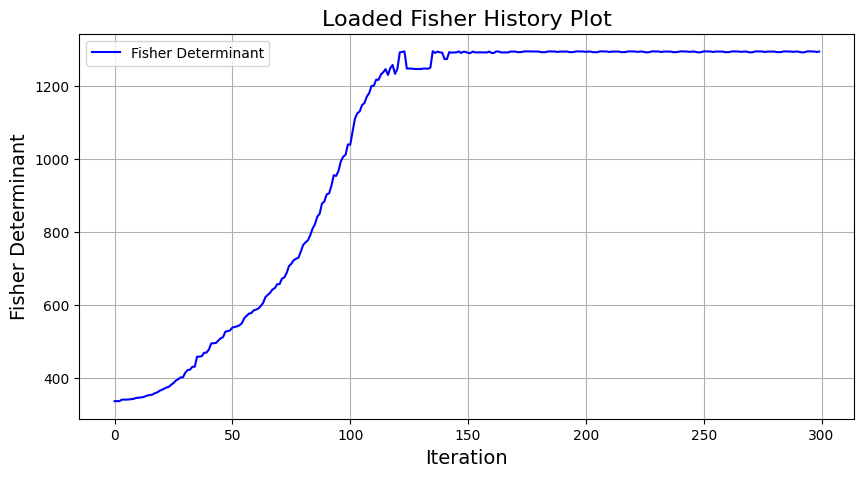

In [30]:
# Load data
iterations = []
fisher_values = []

with open(filename1_fi, "r") as file:
    for line in file:
        data = line.strip().split()  # Split by space
        if len(data) == 2:  # Ensure there are two values (iteration, fisher_value)
            iter_idx, fisher_value = int(data[0]), float(data[1])
            iterations.append(iter_idx)
            fisher_values.append(fisher_value)

# Convert to NumPy array (optional, for easier handling)
iterations = np.array(iterations)
fisher_values = np.array(fisher_values)

# Plot the loaded data
plt.figure(figsize=(10,5))
plt.plot(iterations, fisher_values, color='blue', label="Fisher Determinant")
plt.xlabel("Iteration", fontsize=14)
plt.ylabel("Fisher Determinant", fontsize=14)
plt.title("Loaded Fisher History Plot", fontsize=16)
plt.legend()
plt.grid(True)
plt.show()


### CFI 11 dB

In [40]:
db = 11
epsilon = db_to_epsilon(db)  
print(f"Initial mu: {mu:.4f}")

fisher_history, mu_history = [], []
momentum = 0.9
velocity = 0

for step in tqdm(range(num_steps)):
    # Evaluate F and its determinant at current mu
    F = classical_fisher(mu, epsilon, eta, delta)
    det_F = np.linalg.det(F)

    # Central difference for derivative wrt mu
    delta_mu = 1e-3
    det_F_minus = fisher_det_mu(mu - delta_mu, epsilon, eta, delta)
    det_F_plus  = fisher_det_mu(mu + delta_mu, epsilon, eta, delta)
    grad_mu = (det_F_plus - det_F_minus) / (2 * delta_mu)

    # Clip gradient
    grad_mu = np.clip(grad_mu, -0.01, 0.01)

    # Momentum-based gradient ascent update
    velocity = 0.9 * velocity + learning_rate * grad_mu
    mu += velocity
    mu %= (2 * np.pi)

    # # Gradient ascent step
    # mu += learning_rate * grad_mu
    # mu = mu % (2 * np.pi)

    fisher_history.append(det_F)
    mu_history.append(mu)

    if step % 1 == 0:
        print(f"Step {step}: mu={mu:.4f}, Fisher={det_F:.4e}")

Initial mu: 2.3533


  0%|          | 0/300 [00:00<?, ?it/s]C:\Users\tvle2\AppData\Local\Temp\ipykernel_9076\3418596623.py:92: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
C:\Users\tvle2\AppData\Local\Temp\ipykernel_9076\3418596623.py:117: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
C:\Users\tvle2\AppData\Local\Temp\ipykernel_9076\3418596623.py:118: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
C:\Users\tvle2\AppData\Local\Temp\ipykernel_9076\3418596623.py:119: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  0%|          | 1/300 [02:11<10:56:40, 131.77s/it]

Step 0: mu=2.3533, Fisher=5.6341e+02


  1%|          | 2/300 [04:21<10:47:03, 130.28s/it]

Step 1: mu=2.3533, Fisher=5.6377e+02


  1%|          | 3/300 [06:31<10:46:06, 130.53s/it]

Step 2: mu=2.3533, Fisher=5.6288e+02


  1%|▏         | 4/300 [08:41<10:42:43, 130.28s/it]

Step 3: mu=2.3533, Fisher=5.6842e+02


  2%|▏         | 5/300 [10:51<10:39:13, 130.01s/it]

Step 4: mu=2.3532, Fisher=5.6930e+02


  2%|▏         | 6/300 [13:02<10:38:29, 130.31s/it]

Step 5: mu=2.3532, Fisher=5.6920e+02


  2%|▏         | 7/300 [15:11<10:35:07, 130.06s/it]

Step 6: mu=2.3532, Fisher=5.6986e+02


  3%|▎         | 8/300 [17:21<10:32:46, 130.02s/it]

Step 7: mu=2.3532, Fisher=5.7082e+02


  3%|▎         | 9/300 [19:32<10:31:41, 130.25s/it]

Step 8: mu=2.3531, Fisher=5.7195e+02


  3%|▎         | 10/300 [21:41<10:28:15, 129.98s/it]

Step 9: mu=2.3531, Fisher=5.7566e+02


  4%|▎         | 11/300 [23:52<10:26:38, 130.10s/it]

Step 10: mu=2.3531, Fisher=5.7752e+02


  4%|▍         | 12/300 [26:01<10:23:26, 129.88s/it]

Step 11: mu=2.3530, Fisher=5.7829e+02


  4%|▍         | 13/300 [28:11<10:21:10, 129.86s/it]

Step 12: mu=2.3530, Fisher=5.7935e+02


  5%|▍         | 14/300 [30:22<10:20:26, 130.16s/it]

Step 13: mu=2.3530, Fisher=5.8324e+02


  5%|▌         | 15/300 [32:31<10:17:15, 129.95s/it]

Step 14: mu=2.3529, Fisher=5.8725e+02


  5%|▌         | 16/300 [34:40<10:14:12, 129.76s/it]

Step 15: mu=2.3529, Fisher=5.8851e+02


  6%|▌         | 17/300 [36:51<10:13:24, 130.05s/it]

Step 16: mu=2.3528, Fisher=5.9101e+02


  6%|▌         | 18/300 [39:01<10:10:21, 129.86s/it]

Step 17: mu=2.3528, Fisher=5.9675e+02


  6%|▋         | 19/300 [41:10<10:07:45, 129.77s/it]

Step 18: mu=2.3527, Fisher=6.0022e+02


  7%|▋         | 20/300 [43:21<10:06:53, 130.05s/it]

Step 19: mu=2.3527, Fisher=6.0496e+02


  7%|▋         | 21/300 [45:31<10:04:39, 130.04s/it]

Step 20: mu=2.3527, Fisher=6.0983e+02


  7%|▋         | 22/300 [47:42<10:03:39, 130.29s/it]

Step 21: mu=2.3526, Fisher=6.1489e+02


  8%|▊         | 23/300 [49:52<10:01:27, 130.28s/it]

Step 22: mu=2.3526, Fisher=6.2030e+02


  8%|▊         | 24/300 [52:01<9:57:56, 129.99s/it] 

Step 23: mu=2.3525, Fisher=6.2218e+02


  8%|▊         | 25/300 [54:12<9:56:36, 130.17s/it]

Step 24: mu=2.3525, Fisher=6.3197e+02


  9%|▊         | 26/300 [56:23<9:55:06, 130.31s/it]

Step 25: mu=2.3524, Fisher=6.3896e+02


  9%|▉         | 27/300 [58:32<9:52:10, 130.15s/it]

Step 26: mu=2.3524, Fisher=6.4932e+02


  9%|▉         | 28/300 [1:00:43<9:50:49, 130.33s/it]

Step 27: mu=2.3523, Fisher=6.5622e+02


 10%|▉         | 29/300 [1:02:52<9:47:08, 129.99s/it]

Step 28: mu=2.3523, Fisher=6.6456e+02


 10%|█         | 30/300 [1:05:02<9:43:55, 129.76s/it]

Step 29: mu=2.3522, Fisher=6.6639e+02


 10%|█         | 31/300 [1:07:12<9:42:45, 129.98s/it]

Step 30: mu=2.3522, Fisher=6.8673e+02


 11%|█         | 32/300 [1:09:21<9:39:16, 129.69s/it]

Step 31: mu=2.3521, Fisher=6.9746e+02


 11%|█         | 33/300 [1:11:31<9:37:27, 129.77s/it]

Step 32: mu=2.3521, Fisher=6.9959e+02


 11%|█▏        | 34/300 [1:13:41<9:35:49, 129.89s/it]

Step 33: mu=2.3520, Fisher=7.1405e+02


 12%|█▏        | 35/300 [1:15:50<9:32:32, 129.63s/it]

Step 34: mu=2.3520, Fisher=7.1442e+02


 12%|█▏        | 36/300 [1:18:00<9:31:08, 129.80s/it]

Step 35: mu=2.3519, Fisher=7.5684e+02


 12%|█▏        | 37/300 [1:20:10<9:28:51, 129.78s/it]

Step 36: mu=2.3519, Fisher=7.5676e+02


 13%|█▎        | 38/300 [1:22:19<9:25:48, 129.58s/it]

Step 37: mu=2.3518, Fisher=7.5972e+02


 13%|█▎        | 39/300 [1:24:30<9:25:03, 129.90s/it]

Step 38: mu=2.3518, Fisher=7.7616e+02


 13%|█▎        | 40/300 [1:26:40<9:22:40, 129.85s/it]

Step 39: mu=2.3517, Fisher=7.7713e+02


 14%|█▎        | 41/300 [1:28:49<9:19:41, 129.66s/it]

Step 40: mu=2.3517, Fisher=7.9006e+02


 14%|█▍        | 42/300 [1:30:59<9:18:41, 129.93s/it]

Step 41: mu=2.3516, Fisher=8.1561e+02


 14%|█▍        | 43/300 [1:33:09<9:15:54, 129.78s/it]

Step 42: mu=2.3516, Fisher=8.1693e+02


 15%|█▍        | 44/300 [1:35:18<9:13:29, 129.73s/it]

Step 43: mu=2.3516, Fisher=8.1801e+02


 15%|█▌        | 45/300 [1:37:29<9:12:05, 129.90s/it]

Step 44: mu=2.3515, Fisher=8.2846e+02


 15%|█▌        | 46/300 [1:39:40<9:11:14, 130.21s/it]

Step 45: mu=2.3515, Fisher=8.3776e+02


 16%|█▌        | 47/300 [1:41:50<9:09:31, 130.32s/it]

Step 46: mu=2.3514, Fisher=8.4133e+02


 16%|█▌        | 48/300 [1:44:00<9:06:50, 130.20s/it]

Step 47: mu=2.3514, Fisher=8.6235e+02


 16%|█▋        | 49/300 [1:46:09<9:03:13, 129.85s/it]

Step 48: mu=2.3513, Fisher=8.6400e+02


 17%|█▋        | 50/300 [1:48:20<9:01:54, 130.06s/it]

Step 49: mu=2.3513, Fisher=8.6640e+02


 17%|█▋        | 51/300 [1:50:29<8:59:21, 129.97s/it]

Step 50: mu=2.3512, Fisher=8.7888e+02


 17%|█▋        | 52/300 [1:52:39<8:56:16, 129.74s/it]

Step 51: mu=2.3512, Fisher=8.7997e+02


 18%|█▊        | 53/300 [1:54:49<8:55:00, 129.96s/it]

Step 52: mu=2.3511, Fisher=8.8163e+02


 18%|█▊        | 54/300 [1:56:59<8:52:19, 129.84s/it]

Step 53: mu=2.3511, Fisher=8.8530e+02


 18%|█▊        | 55/300 [1:59:08<8:49:53, 129.77s/it]

Step 54: mu=2.3510, Fisher=8.9377e+02


 19%|█▊        | 56/300 [2:01:19<8:48:24, 129.94s/it]

Step 55: mu=2.3510, Fisher=9.1049e+02


 19%|█▉        | 57/300 [2:03:28<8:45:10, 129.67s/it]

Step 56: mu=2.3509, Fisher=9.1914e+02


 19%|█▉        | 58/300 [2:05:38<8:43:14, 129.73s/it]

Step 57: mu=2.3509, Fisher=9.2821e+02


 20%|█▉        | 59/300 [2:07:47<8:40:42, 129.64s/it]

Step 58: mu=2.3508, Fisher=9.2947e+02


 20%|██        | 60/300 [2:09:56<8:37:39, 129.41s/it]

Step 59: mu=2.3508, Fisher=9.3867e+02


 20%|██        | 61/300 [2:12:06<8:36:27, 129.66s/it]

Step 60: mu=2.3507, Fisher=9.4312e+02


 21%|██        | 62/300 [2:14:16<8:34:26, 129.69s/it]

Step 61: mu=2.3507, Fisher=9.4789e+02


 21%|██        | 63/300 [2:16:25<8:31:29, 129.49s/it]

Step 62: mu=2.3506, Fisher=9.5704e+02


 21%|██▏       | 64/300 [2:18:36<8:30:42, 129.84s/it]

Step 63: mu=2.3506, Fisher=9.6893e+02


 22%|██▏       | 65/300 [2:20:45<8:27:47, 129.65s/it]

Step 64: mu=2.3505, Fisher=9.8857e+02


 22%|██▏       | 66/300 [2:22:54<8:25:06, 129.51s/it]

Step 65: mu=2.3505, Fisher=1.0002e+03


 22%|██▏       | 67/300 [2:25:04<8:23:54, 129.76s/it]

Step 66: mu=2.3504, Fisher=1.0080e+03


 23%|██▎       | 68/300 [2:27:13<8:20:47, 129.52s/it]

Step 67: mu=2.3504, Fisher=1.0223e+03


 23%|██▎       | 69/300 [2:29:23<8:18:50, 129.57s/it]

Step 68: mu=2.3503, Fisher=1.0288e+03


 23%|██▎       | 70/300 [2:31:33<8:17:28, 129.77s/it]

Step 69: mu=2.3503, Fisher=1.0456e+03


 24%|██▎       | 71/300 [2:33:43<8:14:59, 129.69s/it]

Step 70: mu=2.3502, Fisher=1.0463e+03


 24%|██▍       | 72/300 [2:35:53<8:13:13, 129.80s/it]

Step 71: mu=2.3502, Fisher=1.0709e+03


 24%|██▍       | 73/300 [2:38:02<8:10:54, 129.76s/it]

Step 72: mu=2.3501, Fisher=1.0741e+03


 25%|██▍       | 74/300 [2:40:11<8:07:50, 129.52s/it]

Step 73: mu=2.3501, Fisher=1.0946e+03


 25%|██▌       | 75/300 [2:42:23<8:07:31, 130.01s/it]

Step 74: mu=2.3500, Fisher=1.1158e+03


 25%|██▌       | 76/300 [2:44:32<8:04:48, 129.86s/it]

Step 75: mu=2.3500, Fisher=1.1280e+03


 26%|██▌       | 77/300 [2:46:41<8:01:49, 129.64s/it]

Step 76: mu=2.3499, Fisher=1.1451e+03


 26%|██▌       | 78/300 [2:48:52<8:00:43, 129.93s/it]

Step 77: mu=2.3499, Fisher=1.1527e+03


 26%|██▋       | 79/300 [2:51:01<7:57:37, 129.67s/it]

Step 78: mu=2.3498, Fisher=1.1572e+03


 27%|██▋       | 80/300 [2:53:10<7:55:09, 129.59s/it]

Step 79: mu=2.3498, Fisher=1.1855e+03


 27%|██▋       | 81/300 [2:55:21<7:53:50, 129.82s/it]

Step 80: mu=2.3497, Fisher=1.2150e+03


 27%|██▋       | 82/300 [2:57:30<7:50:55, 129.61s/it]

Step 81: mu=2.3497, Fisher=1.2275e+03


 28%|██▊       | 83/300 [2:59:40<7:49:02, 129.69s/it]

Step 82: mu=2.3496, Fisher=1.2409e+03


 28%|██▊       | 84/300 [3:01:49<7:47:06, 129.75s/it]

Step 83: mu=2.3496, Fisher=1.2664e+03


 28%|██▊       | 85/300 [3:03:59<7:44:16, 129.56s/it]

Step 84: mu=2.3495, Fisher=1.2992e+03


 29%|██▊       | 86/300 [3:06:09<7:42:52, 129.78s/it]

Step 85: mu=2.3495, Fisher=1.3225e+03


 29%|██▉       | 87/300 [3:08:19<7:40:36, 129.75s/it]

Step 86: mu=2.3494, Fisher=1.3471e+03


 29%|██▉       | 88/300 [3:10:28<7:37:41, 129.54s/it]

Step 87: mu=2.3494, Fisher=1.3648e+03


 30%|██▉       | 89/300 [3:12:38<7:36:43, 129.87s/it]

Step 88: mu=2.3493, Fisher=1.4183e+03


 30%|███       | 90/300 [3:14:47<7:33:51, 129.67s/it]

Step 89: mu=2.3493, Fisher=1.4286e+03


 30%|███       | 91/300 [3:16:57<7:31:22, 129.58s/it]

Step 90: mu=2.3492, Fisher=1.4641e+03


 31%|███       | 92/300 [3:19:07<7:30:13, 129.87s/it]

Step 91: mu=2.3492, Fisher=1.4698e+03


 31%|███       | 93/300 [3:21:16<7:27:16, 129.64s/it]

Step 92: mu=2.3491, Fisher=1.5107e+03


 31%|███▏      | 94/300 [3:23:26<7:25:10, 129.66s/it]

Step 93: mu=2.3491, Fisher=1.5638e+03


 32%|███▏      | 95/300 [3:25:36<7:23:38, 129.85s/it]

Step 94: mu=2.3490, Fisher=1.5609e+03


 32%|███▏      | 96/300 [3:27:46<7:20:40, 129.61s/it]

Step 95: mu=2.3490, Fisher=1.5829e+03


 32%|███▏      | 97/300 [3:29:55<7:18:52, 129.72s/it]

Step 96: mu=2.3489, Fisher=1.6412e+03


 33%|███▎      | 98/300 [3:32:05<7:16:50, 129.76s/it]

Step 97: mu=2.3489, Fisher=1.6620e+03


 33%|███▎      | 99/300 [3:34:14<7:14:02, 129.56s/it]

Step 98: mu=2.3488, Fisher=1.6739e+03


 33%|███▎      | 100/300 [3:36:25<7:12:48, 129.84s/it]

Step 99: mu=2.3488, Fisher=1.7318e+03


 34%|███▎      | 101/300 [3:38:34<7:10:13, 129.72s/it]

Step 100: mu=2.3487, Fisher=1.7314e+03


 34%|███▍      | 102/300 [3:40:44<7:07:54, 129.67s/it]

Step 101: mu=2.3487, Fisher=1.7816e+03


 34%|███▍      | 103/300 [3:42:54<7:06:27, 129.88s/it]

Step 102: mu=2.3486, Fisher=1.8562e+03


 35%|███▍      | 104/300 [3:45:03<7:03:34, 129.66s/it]

Step 103: mu=2.3486, Fisher=1.8735e+03


 35%|███▌      | 105/300 [3:47:13<7:01:09, 129.59s/it]

Step 104: mu=2.3485, Fisher=1.8851e+03


 35%|███▌      | 106/300 [3:49:23<6:59:52, 129.86s/it]

Step 105: mu=2.3485, Fisher=1.9303e+03


 36%|███▌      | 107/300 [3:51:33<6:57:09, 129.69s/it]

Step 106: mu=2.3484, Fisher=1.9472e+03


 36%|███▌      | 108/300 [3:53:43<6:55:22, 129.81s/it]

Step 107: mu=2.3484, Fisher=1.9757e+03


 36%|███▋      | 109/300 [3:55:53<6:53:19, 129.84s/it]

Step 108: mu=2.3483, Fisher=2.0072e+03


 37%|███▋      | 110/300 [3:58:02<6:50:34, 129.66s/it]

Step 109: mu=2.3483, Fisher=2.0459e+03


 37%|███▋      | 111/300 [4:00:12<6:49:06, 129.87s/it]

Step 110: mu=2.3482, Fisher=2.0502e+03


 37%|███▋      | 112/300 [4:02:22<6:46:56, 129.88s/it]

Step 111: mu=2.3482, Fisher=2.0800e+03


 38%|███▊      | 113/300 [4:04:31<6:44:10, 129.68s/it]

Step 112: mu=2.3481, Fisher=2.0915e+03


 38%|███▊      | 114/300 [4:06:42<6:43:00, 130.01s/it]

Step 113: mu=2.3481, Fisher=2.1184e+03


 38%|███▊      | 115/300 [4:08:51<6:40:04, 129.75s/it]

Step 114: mu=2.3480, Fisher=2.1368e+03


 39%|███▊      | 116/300 [4:11:01<6:37:29, 129.62s/it]

Step 115: mu=2.3480, Fisher=2.1567e+03


 39%|███▉      | 117/300 [4:13:11<6:36:06, 129.87s/it]

Step 116: mu=2.3479, Fisher=2.1316e+03


 39%|███▉      | 118/300 [4:15:20<6:33:16, 129.65s/it]

Step 117: mu=2.3479, Fisher=2.1674e+03


 40%|███▉      | 119/300 [4:17:30<6:31:22, 129.73s/it]

Step 118: mu=2.3478, Fisher=2.1870e+03


 40%|████      | 120/300 [4:19:40<6:29:38, 129.88s/it]

Step 119: mu=2.3478, Fisher=2.1410e+03


 40%|████      | 121/300 [4:21:49<6:26:46, 129.64s/it]

Step 120: mu=2.3477, Fisher=2.1744e+03


 41%|████      | 122/300 [4:24:00<6:25:04, 129.80s/it]

Step 121: mu=2.3477, Fisher=2.2351e+03


 41%|████      | 123/300 [4:26:09<6:22:47, 129.76s/it]

Step 122: mu=2.3476, Fisher=2.2437e+03


 41%|████▏     | 124/300 [4:28:19<6:20:22, 129.67s/it]

Step 123: mu=2.3476, Fisher=2.1637e+03


 42%|████▏     | 125/300 [4:30:30<6:19:29, 130.11s/it]

Step 124: mu=2.3475, Fisher=2.1618e+03


 42%|████▏     | 126/300 [4:32:39<6:16:37, 129.87s/it]

Step 125: mu=2.3475, Fisher=2.1755e+03


 42%|████▏     | 127/300 [4:34:48<6:13:47, 129.64s/it]

Step 126: mu=2.3474, Fisher=2.1859e+03


 43%|████▎     | 128/300 [4:36:59<6:12:18, 129.88s/it]

Step 127: mu=2.3474, Fisher=2.1806e+03


 43%|████▎     | 129/300 [4:39:08<6:09:16, 129.57s/it]

Step 128: mu=2.3474, Fisher=2.2188e+03


 43%|████▎     | 130/300 [4:41:17<6:07:08, 129.58s/it]

Step 129: mu=2.3474, Fisher=2.1453e+03


 44%|████▎     | 131/300 [4:43:28<6:05:38, 129.81s/it]

Step 130: mu=2.3474, Fisher=2.1599e+03


 44%|████▍     | 132/300 [4:45:37<6:02:54, 129.61s/it]

Step 131: mu=2.3474, Fisher=2.1615e+03


 44%|████▍     | 133/300 [4:47:47<6:01:00, 129.71s/it]

Step 132: mu=2.3474, Fisher=2.1599e+03


 45%|████▍     | 134/300 [4:49:56<5:58:48, 129.69s/it]

Step 133: mu=2.3474, Fisher=2.1582e+03


 45%|████▌     | 135/300 [4:52:05<5:55:54, 129.42s/it]

Step 134: mu=2.3474, Fisher=2.2126e+03


 45%|████▌     | 136/300 [4:54:15<5:54:07, 129.56s/it]

Step 135: mu=2.3474, Fisher=2.2214e+03


 46%|████▌     | 137/300 [4:56:24<5:51:54, 129.54s/it]

Step 136: mu=2.3475, Fisher=2.1806e+03


 46%|████▌     | 138/300 [4:58:34<5:49:28, 129.44s/it]

Step 137: mu=2.3475, Fisher=2.1853e+03


 46%|████▋     | 139/300 [5:00:44<5:48:12, 129.77s/it]

Step 138: mu=2.3475, Fisher=2.1891e+03


 47%|████▋     | 140/300 [5:02:53<5:45:35, 129.60s/it]

Step 139: mu=2.3475, Fisher=2.1721e+03


 47%|████▋     | 141/300 [5:05:03<5:43:05, 129.47s/it]

Step 140: mu=2.3476, Fisher=2.1577e+03


 47%|████▋     | 142/300 [5:07:13<5:41:39, 129.74s/it]

Step 141: mu=2.3476, Fisher=2.1618e+03


 48%|████▊     | 143/300 [5:09:22<5:38:57, 129.54s/it]

Step 142: mu=2.3476, Fisher=2.1619e+03


 48%|████▊     | 144/300 [5:11:32<5:36:57, 129.60s/it]

Step 143: mu=2.3476, Fisher=2.1618e+03


 48%|████▊     | 145/300 [5:13:42<5:35:20, 129.81s/it]

Step 144: mu=2.3476, Fisher=2.1597e+03


 49%|████▊     | 146/300 [5:15:51<5:32:44, 129.64s/it]

Step 145: mu=2.3476, Fisher=2.1616e+03


 49%|████▉     | 147/300 [5:18:01<5:31:00, 129.81s/it]

Step 146: mu=2.3476, Fisher=2.1619e+03


 49%|████▉     | 148/300 [5:20:11<5:28:26, 129.65s/it]

Step 147: mu=2.3475, Fisher=2.1618e+03


 50%|████▉     | 149/300 [5:22:20<5:25:56, 129.51s/it]

Step 148: mu=2.3475, Fisher=2.1611e+03


 50%|█████     | 150/300 [5:24:31<5:24:50, 129.94s/it]

Step 149: mu=2.3475, Fisher=2.1699e+03


 50%|█████     | 151/300 [5:26:40<5:22:22, 129.82s/it]

Step 150: mu=2.3475, Fisher=2.1715e+03


 51%|█████     | 152/300 [5:28:50<5:19:43, 129.62s/it]

Step 151: mu=2.3475, Fisher=2.1755e+03


 51%|█████     | 153/300 [5:31:00<5:18:09, 129.86s/it]

Step 152: mu=2.3475, Fisher=2.1755e+03


 51%|█████▏    | 154/300 [5:33:09<5:15:27, 129.64s/it]

Step 153: mu=2.3475, Fisher=2.1724e+03


 52%|█████▏    | 155/300 [5:35:19<5:13:14, 129.62s/it]

Step 154: mu=2.3475, Fisher=2.1699e+03


 52%|█████▏    | 156/300 [5:37:29<5:11:21, 129.73s/it]

Step 155: mu=2.3475, Fisher=2.1596e+03


 52%|█████▏    | 157/300 [5:39:38<5:08:47, 129.57s/it]

Step 156: mu=2.3475, Fisher=2.1574e+03


 53%|█████▎    | 158/300 [5:41:48<5:06:59, 129.72s/it]

Step 157: mu=2.3475, Fisher=2.1574e+03


 53%|█████▎    | 159/300 [5:43:58<5:04:59, 129.78s/it]

Step 158: mu=2.3475, Fisher=2.1577e+03


 53%|█████▎    | 160/300 [5:46:07<5:02:12, 129.52s/it]

Step 159: mu=2.3475, Fisher=2.1587e+03


 54%|█████▎    | 161/300 [5:48:17<5:00:47, 129.84s/it]

Step 160: mu=2.3475, Fisher=2.1666e+03


 54%|█████▍    | 162/300 [5:50:27<4:58:20, 129.72s/it]

Step 161: mu=2.3475, Fisher=2.1721e+03


 54%|█████▍    | 163/300 [5:52:36<4:55:50, 129.57s/it]

Step 162: mu=2.3475, Fisher=2.1721e+03


 55%|█████▍    | 164/300 [5:54:47<4:54:21, 129.87s/it]

Step 163: mu=2.3475, Fisher=2.1715e+03


 55%|█████▌    | 165/300 [5:56:55<4:51:34, 129.59s/it]

Step 164: mu=2.3475, Fisher=2.1699e+03


 55%|█████▌    | 166/300 [5:59:05<4:49:33, 129.66s/it]

Step 165: mu=2.3475, Fisher=2.1603e+03


 56%|█████▌    | 167/300 [6:01:16<4:47:51, 129.86s/it]

Step 166: mu=2.3475, Fisher=2.1574e+03


 56%|█████▌    | 168/300 [6:03:24<4:45:01, 129.56s/it]

Step 167: mu=2.3475, Fisher=2.1597e+03


 56%|█████▋    | 169/300 [6:05:34<4:43:08, 129.69s/it]

Step 168: mu=2.3475, Fisher=2.1582e+03


 57%|█████▋    | 170/300 [6:07:45<4:41:14, 129.81s/it]

Step 169: mu=2.3475, Fisher=2.1587e+03


 57%|█████▋    | 171/300 [6:09:53<4:38:29, 129.53s/it]

Step 170: mu=2.3475, Fisher=2.1665e+03


 57%|█████▋    | 172/300 [6:12:04<4:36:50, 129.77s/it]

Step 171: mu=2.3475, Fisher=2.1724e+03


 58%|█████▊    | 173/300 [6:14:13<4:34:36, 129.74s/it]

Step 172: mu=2.3475, Fisher=2.1761e+03


 58%|█████▊    | 174/300 [6:16:23<4:32:27, 129.74s/it]

Step 173: mu=2.3475, Fisher=2.1923e+03


 58%|█████▊    | 175/300 [6:18:34<4:30:49, 130.00s/it]

Step 174: mu=2.3475, Fisher=2.1961e+03


 59%|█████▊    | 176/300 [6:20:43<4:28:13, 129.78s/it]

Step 175: mu=2.3475, Fisher=2.1754e+03


 59%|█████▉    | 177/300 [6:22:52<4:25:43, 129.62s/it]

Step 176: mu=2.3475, Fisher=2.1724e+03


 59%|█████▉    | 178/300 [6:25:03<4:23:57, 129.81s/it]

Step 177: mu=2.3475, Fisher=2.1699e+03


 60%|█████▉    | 179/300 [6:27:12<4:21:23, 129.62s/it]

Step 178: mu=2.3476, Fisher=2.1597e+03


 60%|██████    | 180/300 [6:29:21<4:19:14, 129.62s/it]

Step 179: mu=2.3476, Fisher=2.1622e+03


 60%|██████    | 181/300 [6:31:32<4:17:33, 129.87s/it]

Step 180: mu=2.3476, Fisher=2.1618e+03


 61%|██████    | 182/300 [6:33:41<4:14:58, 129.65s/it]

Step 181: mu=2.3476, Fisher=2.1618e+03


 61%|██████    | 183/300 [6:35:51<4:13:01, 129.75s/it]

Step 182: mu=2.3475, Fisher=2.1618e+03


 61%|██████▏   | 184/300 [6:38:01<4:10:51, 129.75s/it]

Step 183: mu=2.3475, Fisher=2.1597e+03


 62%|██████▏   | 185/300 [6:40:10<4:08:12, 129.50s/it]

Step 184: mu=2.3475, Fisher=2.1587e+03


 62%|██████▏   | 186/300 [6:42:20<4:06:35, 129.78s/it]

Step 185: mu=2.3475, Fisher=2.1724e+03


 62%|██████▏   | 187/300 [6:44:30<4:04:33, 129.86s/it]

Step 186: mu=2.3475, Fisher=2.1761e+03


 63%|██████▎   | 188/300 [6:46:39<4:02:02, 129.66s/it]

Step 187: mu=2.3475, Fisher=2.1961e+03


 63%|██████▎   | 189/300 [6:48:50<4:00:21, 129.92s/it]

Step 188: mu=2.3475, Fisher=2.1961e+03


 63%|██████▎   | 190/300 [6:50:59<3:57:32, 129.57s/it]

Step 189: mu=2.3475, Fisher=2.1754e+03


 64%|██████▎   | 191/300 [6:53:08<3:55:12, 129.47s/it]

Step 190: mu=2.3475, Fisher=2.1715e+03


 64%|██████▍   | 192/300 [6:55:18<3:53:33, 129.76s/it]

Step 191: mu=2.3475, Fisher=2.1699e+03


 64%|██████▍   | 193/300 [6:57:27<3:51:06, 129.59s/it]

Step 192: mu=2.3476, Fisher=2.1597e+03


 65%|██████▍   | 194/300 [6:59:37<3:49:06, 129.69s/it]

Step 193: mu=2.3476, Fisher=2.1622e+03


 65%|██████▌   | 195/300 [7:01:48<3:47:15, 129.87s/it]

Step 194: mu=2.3476, Fisher=2.1618e+03


 65%|██████▌   | 196/300 [7:03:57<3:44:41, 129.63s/it]

Step 195: mu=2.3476, Fisher=2.1618e+03


 66%|██████▌   | 197/300 [7:06:07<3:42:48, 129.79s/it]

Step 196: mu=2.3475, Fisher=2.1618e+03


 66%|██████▌   | 198/300 [7:08:16<3:40:27, 129.68s/it]

Step 197: mu=2.3475, Fisher=2.1597e+03


 66%|██████▋   | 199/300 [7:10:25<3:38:03, 129.54s/it]

Step 198: mu=2.3475, Fisher=2.1587e+03


 67%|██████▋   | 200/300 [7:12:36<3:36:28, 129.88s/it]

Step 199: mu=2.3475, Fisher=2.1724e+03


 67%|██████▋   | 201/300 [7:14:45<3:33:58, 129.69s/it]

Step 200: mu=2.3475, Fisher=2.1761e+03


 67%|██████▋   | 202/300 [7:16:55<3:31:40, 129.60s/it]

Step 201: mu=2.3475, Fisher=2.1961e+03


 68%|██████▊   | 203/300 [7:19:05<3:29:58, 129.88s/it]

Step 202: mu=2.3475, Fisher=2.1961e+03


 68%|██████▊   | 204/300 [7:21:14<3:27:07, 129.45s/it]

Step 203: mu=2.3475, Fisher=2.1754e+03


 68%|██████▊   | 205/300 [7:23:23<3:25:05, 129.53s/it]

Step 204: mu=2.3475, Fisher=2.1715e+03


 69%|██████▊   | 206/300 [7:25:34<3:23:16, 129.75s/it]

Step 205: mu=2.3475, Fisher=2.1699e+03


 69%|██████▉   | 207/300 [7:27:43<3:20:52, 129.60s/it]

Step 206: mu=2.3476, Fisher=2.1597e+03


 69%|██████▉   | 208/300 [7:29:53<3:19:05, 129.84s/it]

Step 207: mu=2.3476, Fisher=2.1622e+03


 70%|██████▉   | 209/300 [7:32:03<3:16:51, 129.80s/it]

Step 208: mu=2.3476, Fisher=2.1618e+03


 70%|███████   | 210/300 [7:34:12<3:14:25, 129.62s/it]

Step 209: mu=2.3476, Fisher=2.1618e+03


 70%|███████   | 211/300 [7:36:23<3:12:41, 129.91s/it]

Step 210: mu=2.3475, Fisher=2.1618e+03


 71%|███████   | 212/300 [7:38:33<3:10:24, 129.82s/it]

Step 211: mu=2.3475, Fisher=2.1597e+03


 71%|███████   | 213/300 [7:40:42<3:08:03, 129.70s/it]

Step 212: mu=2.3475, Fisher=2.1587e+03


 71%|███████▏  | 214/300 [7:42:53<3:06:18, 129.98s/it]

Step 213: mu=2.3475, Fisher=2.1724e+03


 72%|███████▏  | 215/300 [7:45:02<3:03:44, 129.70s/it]

Step 214: mu=2.3475, Fisher=2.1761e+03


 72%|███████▏  | 216/300 [7:47:11<3:01:29, 129.63s/it]

Step 215: mu=2.3475, Fisher=2.1961e+03


 72%|███████▏  | 217/300 [7:49:21<2:59:18, 129.62s/it]

Step 216: mu=2.3475, Fisher=2.1961e+03


 73%|███████▎  | 218/300 [7:51:30<2:57:01, 129.53s/it]

Step 217: mu=2.3475, Fisher=2.1754e+03


 73%|███████▎  | 219/300 [7:53:40<2:55:04, 129.69s/it]

Step 218: mu=2.3475, Fisher=2.1715e+03


 73%|███████▎  | 220/300 [7:55:50<2:52:55, 129.69s/it]

Step 219: mu=2.3475, Fisher=2.1699e+03


 74%|███████▎  | 221/300 [7:57:59<2:50:32, 129.53s/it]

Step 220: mu=2.3476, Fisher=2.1597e+03


 74%|███████▍  | 222/300 [8:00:09<2:48:38, 129.72s/it]

Step 221: mu=2.3476, Fisher=2.1622e+03


 74%|███████▍  | 223/300 [8:02:19<2:46:24, 129.67s/it]

Step 222: mu=2.3476, Fisher=2.1618e+03


 75%|███████▍  | 224/300 [8:04:29<2:44:22, 129.77s/it]

Step 223: mu=2.3476, Fisher=2.1618e+03


 75%|███████▌  | 225/300 [8:06:39<2:42:36, 130.09s/it]

Step 224: mu=2.3475, Fisher=2.1618e+03


 75%|███████▌  | 226/300 [8:08:49<2:40:06, 129.82s/it]

Step 225: mu=2.3475, Fisher=2.1597e+03


 76%|███████▌  | 227/300 [8:10:58<2:37:45, 129.67s/it]

Step 226: mu=2.3475, Fisher=2.1587e+03


 76%|███████▌  | 228/300 [8:13:09<2:35:56, 129.94s/it]

Step 227: mu=2.3475, Fisher=2.1724e+03


 76%|███████▋  | 229/300 [8:15:18<2:33:31, 129.74s/it]

Step 228: mu=2.3475, Fisher=2.1761e+03


 77%|███████▋  | 230/300 [8:17:28<2:31:26, 129.80s/it]

Step 229: mu=2.3475, Fisher=2.1961e+03


 77%|███████▋  | 231/300 [8:19:38<2:29:30, 130.01s/it]

Step 230: mu=2.3475, Fisher=2.1961e+03


 77%|███████▋  | 232/300 [8:21:47<2:27:03, 129.76s/it]

Step 231: mu=2.3475, Fisher=2.1754e+03


 78%|███████▊  | 233/300 [8:23:58<2:25:01, 129.88s/it]

Step 232: mu=2.3475, Fisher=2.1715e+03


 78%|███████▊  | 234/300 [8:26:07<2:22:46, 129.80s/it]

Step 233: mu=2.3475, Fisher=2.1699e+03


 78%|███████▊  | 235/300 [8:28:16<2:20:21, 129.57s/it]

Step 234: mu=2.3476, Fisher=2.1597e+03


 79%|███████▊  | 236/300 [8:30:27<2:18:32, 129.88s/it]

Step 235: mu=2.3476, Fisher=2.1622e+03


 79%|███████▉  | 237/300 [8:32:37<2:16:21, 129.86s/it]

Step 236: mu=2.3476, Fisher=2.1618e+03


 79%|███████▉  | 238/300 [8:34:46<2:14:10, 129.84s/it]

Step 237: mu=2.3476, Fisher=2.1618e+03


 80%|███████▉  | 239/300 [8:36:57<2:12:20, 130.17s/it]

Step 238: mu=2.3475, Fisher=2.1618e+03


 80%|████████  | 240/300 [8:39:06<2:09:49, 129.82s/it]

Step 239: mu=2.3475, Fisher=2.1597e+03


 80%|████████  | 241/300 [8:41:16<2:07:32, 129.70s/it]

Step 240: mu=2.3475, Fisher=2.1587e+03


 81%|████████  | 242/300 [8:43:26<2:05:34, 129.90s/it]

Step 241: mu=2.3475, Fisher=2.1724e+03


 81%|████████  | 243/300 [8:45:35<2:03:14, 129.73s/it]

Step 242: mu=2.3475, Fisher=2.1761e+03


 81%|████████▏ | 244/300 [8:47:45<2:01:07, 129.78s/it]

Step 243: mu=2.3475, Fisher=2.1961e+03


 82%|████████▏ | 245/300 [8:49:55<1:58:59, 129.81s/it]

Step 244: mu=2.3475, Fisher=2.1961e+03


 82%|████████▏ | 246/300 [8:52:04<1:56:37, 129.59s/it]

Step 245: mu=2.3475, Fisher=2.1754e+03


 82%|████████▏ | 247/300 [8:54:15<1:54:43, 129.88s/it]

Step 246: mu=2.3475, Fisher=2.1715e+03


 83%|████████▎ | 248/300 [8:56:25<1:52:32, 129.86s/it]

Step 247: mu=2.3475, Fisher=2.1699e+03


 83%|████████▎ | 249/300 [8:58:34<1:50:10, 129.62s/it]

Step 248: mu=2.3476, Fisher=2.1597e+03


 83%|████████▎ | 250/300 [9:00:44<1:48:14, 129.89s/it]

Step 249: mu=2.3476, Fisher=2.1622e+03


 84%|████████▎ | 251/300 [9:02:53<1:45:54, 129.68s/it]

Step 250: mu=2.3476, Fisher=2.1618e+03


 84%|████████▍ | 252/300 [9:05:03<1:43:41, 129.61s/it]

Step 251: mu=2.3476, Fisher=2.1618e+03


 84%|████████▍ | 253/300 [9:07:13<1:41:43, 129.87s/it]

Step 252: mu=2.3475, Fisher=2.1618e+03


 85%|████████▍ | 254/300 [9:09:23<1:39:24, 129.65s/it]

Step 253: mu=2.3475, Fisher=2.1597e+03


 85%|████████▌ | 255/300 [9:11:32<1:37:17, 129.73s/it]

Step 254: mu=2.3475, Fisher=2.1587e+03


 85%|████████▌ | 256/300 [9:13:43<1:35:13, 129.86s/it]

Step 255: mu=2.3475, Fisher=2.1724e+03


 86%|████████▌ | 257/300 [9:15:52<1:32:54, 129.64s/it]

Step 256: mu=2.3475, Fisher=2.1761e+03


 86%|████████▌ | 258/300 [9:18:02<1:30:52, 129.83s/it]

Step 257: mu=2.3475, Fisher=2.1961e+03


 86%|████████▋ | 259/300 [9:20:12<1:28:40, 129.76s/it]

Step 258: mu=2.3475, Fisher=2.1961e+03


 87%|████████▋ | 260/300 [9:22:21<1:26:21, 129.53s/it]

Step 259: mu=2.3475, Fisher=2.1754e+03


 87%|████████▋ | 261/300 [9:24:31<1:24:24, 129.86s/it]

Step 260: mu=2.3475, Fisher=2.1715e+03


 87%|████████▋ | 262/300 [9:26:41<1:22:09, 129.74s/it]

Step 261: mu=2.3475, Fisher=2.1699e+03


 88%|████████▊ | 263/300 [9:28:50<1:19:53, 129.56s/it]

Step 262: mu=2.3476, Fisher=2.1597e+03


 88%|████████▊ | 264/300 [9:31:00<1:17:53, 129.81s/it]

Step 263: mu=2.3476, Fisher=2.1622e+03


 88%|████████▊ | 265/300 [9:33:09<1:15:35, 129.58s/it]

Step 264: mu=2.3476, Fisher=2.1618e+03


 89%|████████▊ | 266/300 [9:35:19<1:13:27, 129.62s/it]

Step 265: mu=2.3476, Fisher=2.1618e+03


 89%|████████▉ | 267/300 [9:37:29<1:11:25, 129.88s/it]

Step 266: mu=2.3475, Fisher=2.1618e+03


 89%|████████▉ | 268/300 [9:39:39<1:09:09, 129.67s/it]

Step 267: mu=2.3475, Fisher=2.1597e+03


 90%|████████▉ | 269/300 [9:41:49<1:07:02, 129.76s/it]

Step 268: mu=2.3475, Fisher=2.1587e+03


 90%|█████████ | 270/300 [9:43:58<1:04:52, 129.76s/it]

Step 269: mu=2.3475, Fisher=2.1724e+03


 90%|█████████ | 271/300 [9:46:07<1:02:36, 129.53s/it]

Step 270: mu=2.3475, Fisher=2.1761e+03


 91%|█████████ | 272/300 [9:48:18<1:00:33, 129.78s/it]

Step 271: mu=2.3475, Fisher=2.1961e+03


 91%|█████████ | 273/300 [9:50:28<58:28, 129.93s/it]  

Step 272: mu=2.3475, Fisher=2.1961e+03


 91%|█████████▏| 274/300 [9:52:37<56:13, 129.73s/it]

Step 273: mu=2.3475, Fisher=2.1754e+03


 92%|█████████▏| 275/300 [9:54:48<54:09, 129.96s/it]

Step 274: mu=2.3475, Fisher=2.1715e+03


 92%|█████████▏| 276/300 [9:56:57<51:52, 129.69s/it]

Step 275: mu=2.3475, Fisher=2.1699e+03


 92%|█████████▏| 277/300 [9:59:06<49:39, 129.55s/it]

Step 276: mu=2.3476, Fisher=2.1597e+03


 93%|█████████▎| 278/300 [10:01:16<47:35, 129.80s/it]

Step 277: mu=2.3476, Fisher=2.1622e+03


 93%|█████████▎| 279/300 [10:03:26<45:24, 129.75s/it]

Step 278: mu=2.3476, Fisher=2.1618e+03


 93%|█████████▎| 280/300 [10:05:36<43:18, 129.91s/it]

Step 279: mu=2.3476, Fisher=2.1618e+03


 94%|█████████▎| 281/300 [10:07:47<41:12, 130.15s/it]

Step 280: mu=2.3475, Fisher=2.1618e+03


 94%|█████████▍| 282/300 [10:09:56<38:55, 129.73s/it]

Step 281: mu=2.3475, Fisher=2.1597e+03


 94%|█████████▍| 283/300 [10:12:06<36:46, 129.80s/it]

Step 282: mu=2.3475, Fisher=2.1587e+03


 95%|█████████▍| 284/300 [10:14:15<34:35, 129.71s/it]

Step 283: mu=2.3475, Fisher=2.1724e+03


 95%|█████████▌| 285/300 [10:16:24<32:21, 129.46s/it]

Step 284: mu=2.3475, Fisher=2.1761e+03


 95%|█████████▌| 286/300 [10:18:35<30:16, 129.77s/it]

Step 285: mu=2.3475, Fisher=2.1961e+03


 96%|█████████▌| 287/300 [10:20:44<28:04, 129.57s/it]

Step 286: mu=2.3475, Fisher=2.1961e+03


 96%|█████████▌| 288/300 [10:22:53<25:53, 129.45s/it]

Step 287: mu=2.3475, Fisher=2.1754e+03


 96%|█████████▋| 289/300 [10:25:03<23:46, 129.67s/it]

Step 288: mu=2.3475, Fisher=2.1715e+03


 97%|█████████▋| 290/300 [10:27:12<21:34, 129.49s/it]

Step 289: mu=2.3475, Fisher=2.1699e+03


 97%|█████████▋| 291/300 [10:29:22<19:25, 129.47s/it]

Step 290: mu=2.3476, Fisher=2.1597e+03


 97%|█████████▋| 292/300 [10:31:32<17:17, 129.70s/it]

Step 291: mu=2.3476, Fisher=2.1622e+03


 98%|█████████▊| 293/300 [10:33:41<15:06, 129.49s/it]

Step 292: mu=2.3476, Fisher=2.1618e+03


 98%|█████████▊| 294/300 [10:35:50<12:57, 129.54s/it]

Step 293: mu=2.3476, Fisher=2.1618e+03


 98%|█████████▊| 295/300 [10:38:00<10:47, 129.57s/it]

Step 294: mu=2.3475, Fisher=2.1618e+03


 99%|█████████▊| 296/300 [10:40:09<08:37, 129.42s/it]

Step 295: mu=2.3475, Fisher=2.1597e+03


 99%|█████████▉| 297/300 [10:42:19<06:29, 129.68s/it]

Step 296: mu=2.3475, Fisher=2.1587e+03


 99%|█████████▉| 298/300 [10:44:29<04:19, 129.60s/it]

Step 297: mu=2.3475, Fisher=2.1724e+03


100%|█████████▉| 299/300 [10:46:38<02:09, 129.54s/it]

Step 298: mu=2.3475, Fisher=2.1761e+03


100%|██████████| 300/300 [10:48:49<00:00, 129.77s/it]

Step 299: mu=2.3475, Fisher=2.1961e+03


In [41]:
filename2_fi = f"C:/Users/tvle2/Documents/Code/Bosonic/dataset/fisher_history_11.txt"
filename2_mu = f"C:/Users/tvle2/Documents/Code/Bosonic/dataset/mu_11.txt"
with open(filename2_fi, "w") as file:
    for i, fisher_value in enumerate(fisher_history):
        file.write(f"{i} {fisher_value}\n")
with open(filename2_mu, "w") as file:
    for i, mu_value in enumerate(mu_history):
        file.write(f"{i} {mu_value}\n")


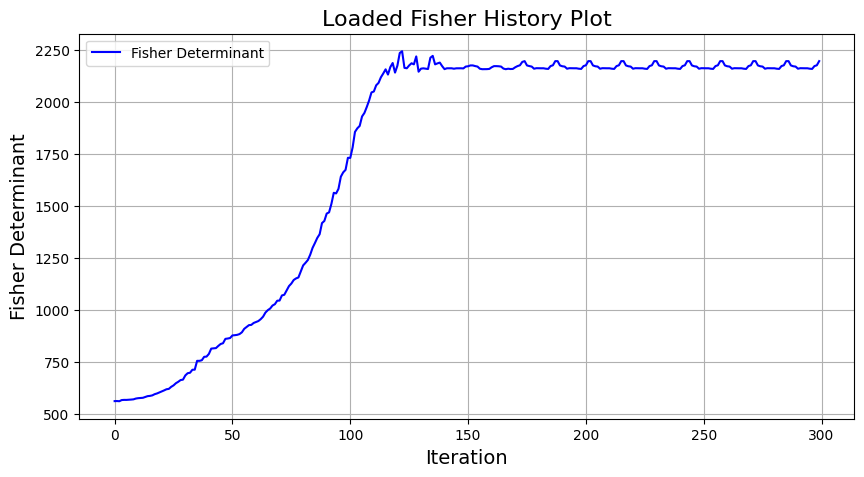

In [42]:
# Load data
iterations = []
fisher_values = []

with open(filename2_fi, "r") as file:
    for line in file:
        data = line.strip().split()  # Split by space
        if len(data) == 2:  # Ensure there are two values (iteration, fisher_value)
            iter_idx, fisher_value = int(data[0]), float(data[1])
            iterations.append(iter_idx)
            fisher_values.append(fisher_value)

# Convert to NumPy array (optional, for easier handling)
iterations = np.array(iterations)
fisher_values = np.array(fisher_values)

# Plot the loaded data
plt.figure(figsize=(10,5))
plt.plot(iterations, fisher_values, color='blue', label="Fisher Determinant")
plt.xlabel("Iteration", fontsize=14)
plt.ylabel("Fisher Determinant", fontsize=14)
plt.title("Loaded Fisher History Plot", fontsize=16)
plt.legend()
plt.grid(True)
plt.show()


### CFI 12 dB

In [46]:
db = 12
epsilon = db_to_epsilon(db)  
print(f"Initial mu: {mu:.4f}")

fisher_history, mu_history = [], []
momentum = 0.9
velocity = 0

for step in tqdm(range(num_steps)):
    # Evaluate F and its determinant at current mu
    F = classical_fisher(mu, epsilon, eta, delta)
    det_F = np.linalg.det(F)

    # Central difference for derivative wrt mu
    delta_mu = 1e-3
    det_F_minus = fisher_det_mu(mu - delta_mu, epsilon, eta, delta)
    det_F_plus  = fisher_det_mu(mu + delta_mu, epsilon, eta, delta)
    grad_mu = (det_F_plus - det_F_minus) / (2 * delta_mu)

    # Clip gradient
    grad_mu = np.clip(grad_mu, -0.01, 0.01)

    # Momentum-based gradient ascent update
    velocity = 0.9 * velocity + learning_rate * grad_mu
    mu += velocity
    mu %= (2 * np.pi)

    # # Gradient ascent step
    # mu += learning_rate * grad_mu
    # mu = mu % (2 * np.pi)

    fisher_history.append(det_F)
    mu_history.append(mu)

    if step % 1 == 0:
        print(f"Step {step}: mu={mu:.4f}, Fisher={det_F:.4e}")

Initial mu: 2.3533


  0%|          | 0/300 [00:00<?, ?it/s]C:\Users\tvle2\AppData\Local\Temp\ipykernel_9076\3418596623.py:92: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
C:\Users\tvle2\AppData\Local\Temp\ipykernel_9076\3418596623.py:117: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
C:\Users\tvle2\AppData\Local\Temp\ipykernel_9076\3418596623.py:118: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
C:\Users\tvle2\AppData\Local\Temp\ipykernel_9076\3418596623.py:119: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  0%|          | 1/300 [02:37<13:04:07, 157.35s/it]

Step 0: mu=2.3533, Fisher=9.1295e+02


  1%|          | 2/300 [05:13<12:58:05, 156.66s/it]

Step 1: mu=2.3533, Fisher=9.1340e+02


  1%|          | 3/300 [07:50<12:56:47, 156.93s/it]

Step 2: mu=2.3533, Fisher=9.1174e+02


  1%|▏         | 4/300 [10:25<12:50:35, 156.20s/it]

Step 3: mu=2.3533, Fisher=9.1881e+02


  2%|▏         | 5/300 [13:02<12:49:31, 156.51s/it]

Step 4: mu=2.3532, Fisher=9.2057e+02


  2%|▏         | 6/300 [15:38<12:44:39, 156.05s/it]

Step 5: mu=2.3532, Fisher=9.2052e+02


  2%|▏         | 7/300 [18:14<12:42:15, 156.09s/it]

Step 6: mu=2.3532, Fisher=9.2129e+02


  3%|▎         | 8/300 [20:50<12:40:11, 156.20s/it]

Step 7: mu=2.3532, Fisher=9.2271e+02


  3%|▎         | 9/300 [23:26<12:36:31, 155.98s/it]

Step 8: mu=2.3531, Fisher=9.2406e+02


  3%|▎         | 10/300 [26:02<12:35:04, 156.22s/it]

Step 9: mu=2.3531, Fisher=9.2930e+02


  4%|▎         | 11/300 [28:38<12:32:11, 156.16s/it]

Step 10: mu=2.3531, Fisher=9.3313e+02


  4%|▍         | 12/300 [31:15<12:30:16, 156.31s/it]

Step 11: mu=2.3530, Fisher=9.3397e+02


  4%|▍         | 13/300 [33:50<12:25:45, 155.91s/it]

Step 12: mu=2.3530, Fisher=9.3495e+02


  5%|▍         | 14/300 [36:26<12:23:43, 156.03s/it]

Step 13: mu=2.3530, Fisher=9.4116e+02


  5%|▌         | 15/300 [39:02<12:21:02, 156.01s/it]

Step 14: mu=2.3529, Fisher=9.4738e+02


  5%|▌         | 16/300 [41:37<12:16:50, 155.67s/it]

Step 15: mu=2.3529, Fisher=9.4877e+02


  6%|▌         | 17/300 [44:14<12:15:40, 155.97s/it]

Step 16: mu=2.3528, Fisher=9.5282e+02


  6%|▌         | 18/300 [46:49<12:11:49, 155.71s/it]

Step 17: mu=2.3528, Fisher=9.6102e+02


  6%|▋         | 19/300 [49:26<12:10:21, 155.95s/it]

Step 18: mu=2.3527, Fisher=9.6633e+02


  7%|▋         | 20/300 [52:01<12:06:53, 155.76s/it]

Step 19: mu=2.3527, Fisher=9.7076e+02


  7%|▋         | 21/300 [54:37<12:04:49, 155.88s/it]

Step 20: mu=2.3527, Fisher=9.7809e+02


  7%|▋         | 22/300 [57:12<12:01:30, 155.72s/it]

Step 21: mu=2.3526, Fisher=9.8532e+02


  8%|▊         | 23/300 [59:48<11:58:09, 155.56s/it]

Step 22: mu=2.3526, Fisher=9.9382e+02


  8%|▊         | 24/300 [1:02:24<11:56:24, 155.74s/it]

Step 23: mu=2.3525, Fisher=9.9447e+02


  8%|▊         | 25/300 [1:04:59<11:53:09, 155.60s/it]

Step 24: mu=2.3525, Fisher=1.0098e+03


  9%|▊         | 26/300 [1:07:36<11:52:10, 155.95s/it]

Step 25: mu=2.3524, Fisher=1.0200e+03


  9%|▉         | 27/300 [1:10:11<11:48:32, 155.72s/it]

Step 26: mu=2.3524, Fisher=1.0341e+03


  9%|▉         | 28/300 [1:12:48<11:47:05, 155.97s/it]

Step 27: mu=2.3523, Fisher=1.0454e+03


 10%|▉         | 29/300 [1:15:24<11:44:32, 155.99s/it]

Step 28: mu=2.3523, Fisher=1.0586e+03


 10%|█         | 30/300 [1:18:00<11:42:24, 156.09s/it]

Step 29: mu=2.3522, Fisher=1.0630e+03


 10%|█         | 31/300 [1:20:36<11:39:40, 156.06s/it]

Step 30: mu=2.3522, Fisher=1.0932e+03


 11%|█         | 32/300 [1:23:11<11:35:52, 155.79s/it]

Step 31: mu=2.3521, Fisher=1.1073e+03


 11%|█         | 33/300 [1:25:47<11:33:58, 155.95s/it]

Step 32: mu=2.3521, Fisher=1.1119e+03


 11%|█▏        | 34/300 [1:28:22<11:30:09, 155.68s/it]

Step 33: mu=2.3520, Fisher=1.1346e+03


 12%|█▏        | 35/300 [1:30:58<11:28:05, 155.79s/it]

Step 34: mu=2.3520, Fisher=1.1354e+03


 12%|█▏        | 36/300 [1:33:34<11:24:31, 155.57s/it]

Step 35: mu=2.3519, Fisher=1.1924e+03


 12%|█▏        | 37/300 [1:36:10<11:22:31, 155.71s/it]

Step 36: mu=2.3519, Fisher=1.1922e+03


 13%|█▎        | 38/300 [1:38:46<11:20:18, 155.80s/it]

Step 37: mu=2.3518, Fisher=1.1979e+03


 13%|█▎        | 39/300 [1:41:21<11:17:40, 155.79s/it]

Step 38: mu=2.3518, Fisher=1.2231e+03


 13%|█▎        | 40/300 [1:43:58<11:16:15, 156.06s/it]

Step 39: mu=2.3517, Fisher=1.2254e+03


 14%|█▎        | 41/300 [1:46:34<11:12:57, 155.90s/it]

Step 40: mu=2.3517, Fisher=1.2427e+03


 14%|█▍        | 42/300 [1:49:10<11:11:40, 156.21s/it]

Step 41: mu=2.3516, Fisher=1.2776e+03


 14%|█▍        | 43/300 [1:51:45<11:07:26, 155.82s/it]

Step 42: mu=2.3516, Fisher=1.2801e+03


 15%|█▍        | 44/300 [1:54:21<11:04:50, 155.82s/it]

Step 43: mu=2.3516, Fisher=1.2812e+03


 15%|█▌        | 45/300 [1:56:57<11:02:42, 155.93s/it]

Step 44: mu=2.3515, Fisher=1.2941e+03


 15%|█▌        | 46/300 [1:59:32<10:58:48, 155.62s/it]

Step 45: mu=2.3515, Fisher=1.3068e+03


 16%|█▌        | 47/300 [2:02:09<10:57:33, 155.94s/it]

Step 46: mu=2.3514, Fisher=1.3088e+03


 16%|█▌        | 48/300 [2:04:44<10:53:45, 155.66s/it]

Step 47: mu=2.3514, Fisher=1.3331e+03


 16%|█▋        | 49/300 [2:07:21<10:52:53, 156.07s/it]

Step 48: mu=2.3513, Fisher=1.3354e+03


 17%|█▋        | 50/300 [2:09:56<10:48:54, 155.74s/it]

Step 49: mu=2.3513, Fisher=1.3374e+03


 17%|█▋        | 51/300 [2:12:32<10:46:54, 155.88s/it]

Step 50: mu=2.3512, Fisher=1.3547e+03


 17%|█▋        | 52/300 [2:15:08<10:44:48, 156.00s/it]

Step 51: mu=2.3512, Fisher=1.3538e+03


 18%|█▊        | 53/300 [2:17:45<10:42:31, 156.08s/it]

Step 52: mu=2.3511, Fisher=1.3550e+03


 18%|█▊        | 54/300 [2:20:22<10:41:41, 156.51s/it]

Step 53: mu=2.3511, Fisher=1.3588e+03


 18%|█▊        | 55/300 [2:22:58<10:38:00, 156.25s/it]

Step 54: mu=2.3510, Fisher=1.3707e+03


 19%|█▊        | 56/300 [2:25:35<10:36:28, 156.51s/it]

Step 55: mu=2.3510, Fisher=1.3860e+03


 19%|█▉        | 57/300 [2:28:11<10:33:30, 156.42s/it]

Step 56: mu=2.3509, Fisher=1.3972e+03


 19%|█▉        | 58/300 [2:30:48<10:31:24, 156.55s/it]

Step 57: mu=2.3509, Fisher=1.4090e+03


 20%|█▉        | 59/300 [2:33:24<10:27:36, 156.25s/it]

Step 58: mu=2.3508, Fisher=1.4087e+03


 20%|██        | 60/300 [2:36:00<10:24:54, 156.23s/it]

Step 59: mu=2.3508, Fisher=1.4191e+03


 20%|██        | 61/300 [2:38:37<10:23:09, 156.44s/it]

Step 60: mu=2.3507, Fisher=1.4286e+03


 21%|██        | 62/300 [2:41:13<10:19:47, 156.25s/it]

Step 61: mu=2.3507, Fisher=1.4358e+03


 21%|██        | 63/300 [2:43:50<10:18:18, 156.53s/it]

Step 62: mu=2.3506, Fisher=1.4468e+03


 21%|██▏       | 64/300 [2:46:25<10:14:14, 156.16s/it]

Step 63: mu=2.3506, Fisher=1.4617e+03


 22%|██▏       | 65/300 [2:49:02<10:13:01, 156.52s/it]

Step 64: mu=2.3505, Fisher=1.4828e+03


 22%|██▏       | 66/300 [2:51:38<10:09:37, 156.31s/it]

Step 65: mu=2.3505, Fisher=1.5038e+03


 22%|██▏       | 67/300 [2:54:14<10:06:48, 156.26s/it]

Step 66: mu=2.3504, Fisher=1.5126e+03


 23%|██▎       | 68/300 [2:56:51<10:04:55, 156.45s/it]

Step 67: mu=2.3504, Fisher=1.5339e+03


 23%|██▎       | 69/300 [2:59:27<10:01:07, 156.14s/it]

Step 68: mu=2.3503, Fisher=1.5448e+03


 23%|██▎       | 70/300 [3:02:04<10:00:11, 156.57s/it]

Step 69: mu=2.3503, Fisher=1.5688e+03


 24%|██▎       | 71/300 [3:04:41<9:57:19, 156.51s/it] 

Step 70: mu=2.3502, Fisher=1.5740e+03


 24%|██▍       | 72/300 [3:07:18<9:56:06, 156.87s/it]

Step 71: mu=2.3502, Fisher=1.6118e+03


 24%|██▍       | 73/300 [3:09:54<9:51:48, 156.43s/it]

Step 72: mu=2.3501, Fisher=1.6142e+03


 25%|██▍       | 74/300 [3:12:30<9:49:28, 156.50s/it]

Step 73: mu=2.3501, Fisher=1.6419e+03


 25%|██▌       | 75/300 [3:15:07<9:46:57, 156.52s/it]

Step 74: mu=2.3500, Fisher=1.6659e+03


 25%|██▌       | 76/300 [3:17:42<9:43:07, 156.19s/it]

Step 75: mu=2.3500, Fisher=1.6870e+03


 26%|██▌       | 77/300 [3:20:20<9:41:51, 156.56s/it]

Step 76: mu=2.3499, Fisher=1.7141e+03


 26%|██▌       | 78/300 [3:22:55<9:37:32, 156.09s/it]

Step 77: mu=2.3499, Fisher=1.7276e+03


 26%|██▋       | 79/300 [3:25:32<9:36:10, 156.43s/it]

Step 78: mu=2.3498, Fisher=1.7366e+03


 27%|██▋       | 80/300 [3:28:08<9:32:54, 156.25s/it]

Step 79: mu=2.3498, Fisher=1.7808e+03


 27%|██▋       | 81/300 [3:30:45<9:30:54, 156.41s/it]

Step 80: mu=2.3497, Fisher=1.8214e+03


 27%|██▋       | 82/300 [3:33:21<9:28:07, 156.37s/it]

Step 81: mu=2.3497, Fisher=1.8424e+03


 28%|██▊       | 83/300 [3:35:59<9:27:21, 156.87s/it]

Step 82: mu=2.3496, Fisher=1.8717e+03


 28%|██▊       | 84/300 [3:39:16<10:07:38, 168.79s/it]

Step 83: mu=2.3496, Fisher=1.9155e+03


 28%|██▊       | 85/300 [3:41:50<9:49:52, 164.61s/it] 

Step 84: mu=2.3495, Fisher=1.9648e+03


 29%|██▊       | 86/300 [3:46:44<12:04:43, 203.19s/it]

Step 85: mu=2.3495, Fisher=2.0028e+03


 29%|██▉       | 87/300 [3:50:24<12:20:09, 208.50s/it]

Step 86: mu=2.3494, Fisher=2.0298e+03


 29%|██▉       | 88/300 [3:52:58<11:18:41, 192.08s/it]

Step 87: mu=2.3494, Fisher=2.0632e+03


 30%|██▉       | 89/300 [3:55:36<10:38:59, 181.70s/it]

Step 88: mu=2.3493, Fisher=2.1481e+03


 30%|███       | 90/300 [3:58:11<10:08:32, 173.87s/it]

Step 89: mu=2.3493, Fisher=2.1683e+03


 30%|███       | 91/300 [4:00:47<9:47:09, 168.56s/it] 

Step 90: mu=2.3492, Fisher=2.2234e+03


 31%|███       | 92/300 [4:03:23<9:30:50, 164.67s/it]

Step 91: mu=2.3492, Fisher=2.2343e+03


 31%|███       | 93/300 [4:05:59<9:18:32, 161.89s/it]

Step 92: mu=2.3491, Fisher=2.3044e+03


 31%|███▏      | 94/300 [4:08:35<9:09:54, 160.17s/it]

Step 93: mu=2.3491, Fisher=2.3847e+03


 32%|███▏      | 95/300 [4:11:10<9:02:12, 158.69s/it]

Step 94: mu=2.3490, Fisher=2.3819e+03


 32%|███▏      | 96/300 [4:13:46<8:57:10, 157.99s/it]

Step 95: mu=2.3490, Fisher=2.4140e+03


 32%|███▏      | 97/300 [4:16:21<8:51:37, 157.13s/it]

Step 96: mu=2.3489, Fisher=2.5221e+03


 33%|███▎      | 98/300 [4:18:58<8:48:24, 156.95s/it]

Step 97: mu=2.3489, Fisher=2.5517e+03


 33%|███▎      | 99/300 [4:21:33<8:44:00, 156.42s/it]

Step 98: mu=2.3488, Fisher=2.5740e+03


 33%|███▎      | 100/300 [4:24:09<8:40:48, 156.24s/it]

Step 99: mu=2.3488, Fisher=2.6698e+03


 34%|███▎      | 101/300 [4:26:45<8:37:55, 156.16s/it]

Step 100: mu=2.3487, Fisher=2.6713e+03


 34%|███▍      | 102/300 [4:29:20<8:34:41, 155.97s/it]

Step 101: mu=2.3487, Fisher=2.7334e+03


 34%|███▍      | 103/300 [4:31:57<8:32:40, 156.14s/it]

Step 102: mu=2.3486, Fisher=2.8633e+03


 35%|███▍      | 104/300 [4:34:32<8:28:54, 155.79s/it]

Step 103: mu=2.3486, Fisher=2.8822e+03


 35%|███▌      | 105/300 [4:37:09<8:27:13, 156.07s/it]

Step 104: mu=2.3485, Fisher=2.9054e+03


 35%|███▌      | 106/300 [4:39:44<8:23:39, 155.77s/it]

Step 105: mu=2.3485, Fisher=2.9947e+03


 36%|███▌      | 107/300 [4:42:20<8:21:15, 155.83s/it]

Step 106: mu=2.3484, Fisher=3.0352e+03


 36%|███▌      | 108/300 [4:44:57<8:20:08, 156.29s/it]

Step 107: mu=2.3484, Fisher=3.0767e+03


 36%|███▋      | 109/300 [4:47:36<8:19:58, 157.06s/it]

Step 108: mu=2.3483, Fisher=3.1450e+03


 37%|███▋      | 110/300 [4:50:17<8:21:01, 158.22s/it]

Step 109: mu=2.3483, Fisher=3.2158e+03


 37%|███▋      | 111/300 [4:52:56<8:19:16, 158.50s/it]

Step 110: mu=2.3482, Fisher=3.2300e+03


 37%|███▋      | 112/300 [4:55:37<8:18:51, 159.21s/it]

Step 111: mu=2.3482, Fisher=3.2804e+03


 38%|███▊      | 113/300 [4:58:16<8:16:18, 159.25s/it]

Step 112: mu=2.3481, Fisher=3.3188e+03


 38%|███▊      | 114/300 [5:00:56<8:14:29, 159.51s/it]

Step 113: mu=2.3481, Fisher=3.3657e+03


 38%|███▊      | 115/300 [5:03:35<8:11:17, 159.34s/it]

Step 114: mu=2.3480, Fisher=3.4130e+03


 39%|███▊      | 116/300 [5:06:14<8:08:28, 159.28s/it]

Step 115: mu=2.3480, Fisher=3.4497e+03


 39%|███▉      | 117/300 [5:08:54<8:05:56, 159.32s/it]

Step 116: mu=2.3479, Fisher=3.4256e+03


 39%|███▉      | 118/300 [5:11:32<8:02:17, 159.00s/it]

Step 117: mu=2.3479, Fisher=3.4911e+03


 40%|███▉      | 119/300 [5:14:12<8:00:32, 159.30s/it]

Step 118: mu=2.3478, Fisher=3.5322e+03


 40%|████      | 120/300 [5:16:50<7:56:29, 158.83s/it]

Step 119: mu=2.3478, Fisher=3.4737e+03


 40%|████      | 121/300 [5:19:30<7:54:43, 159.12s/it]

Step 120: mu=2.3477, Fisher=3.5433e+03


 41%|████      | 122/300 [5:22:08<7:51:37, 158.97s/it]

Step 121: mu=2.3477, Fisher=3.6052e+03


 41%|████      | 123/300 [5:24:45<7:47:22, 158.43s/it]

Step 122: mu=2.3476, Fisher=3.6285e+03


 41%|████▏     | 124/300 [5:27:21<7:42:07, 157.54s/it]

Step 123: mu=2.3476, Fisher=3.5086e+03


 42%|████▏     | 125/300 [5:29:57<7:37:54, 157.00s/it]

Step 124: mu=2.3475, Fisher=3.5142e+03


 42%|████▏     | 126/300 [5:32:33<7:34:51, 156.85s/it]

Step 125: mu=2.3475, Fisher=3.5407e+03


 42%|████▏     | 127/300 [5:35:08<7:30:44, 156.33s/it]

Step 126: mu=2.3474, Fisher=3.5500e+03


 43%|████▎     | 128/300 [5:37:45<7:28:15, 156.37s/it]

Step 127: mu=2.3474, Fisher=3.6141e+03


 43%|████▎     | 129/300 [5:40:20<7:25:01, 156.15s/it]

Step 128: mu=2.3473, Fisher=3.5172e+03


 43%|████▎     | 130/300 [5:42:57<7:22:49, 156.29s/it]

Step 129: mu=2.3473, Fisher=3.5427e+03


 44%|████▎     | 131/300 [5:45:32<7:19:12, 155.93s/it]

Step 130: mu=2.3473, Fisher=3.5672e+03


 44%|████▍     | 132/300 [5:48:08<7:16:37, 155.94s/it]

Step 131: mu=2.3473, Fisher=3.5588e+03


 44%|████▍     | 133/300 [5:50:44<7:14:00, 155.93s/it]

Step 132: mu=2.3473, Fisher=3.5497e+03


 45%|████▍     | 134/300 [5:53:19<7:10:56, 155.76s/it]

Step 133: mu=2.3473, Fisher=3.5496e+03


 45%|████▌     | 135/300 [5:55:56<7:08:51, 155.95s/it]

Step 134: mu=2.3473, Fisher=3.5476e+03


 45%|████▌     | 136/300 [5:58:31<7:05:38, 155.73s/it]

Step 135: mu=2.3473, Fisher=3.5569e+03


 46%|████▌     | 137/300 [6:01:07<7:03:47, 156.00s/it]

Step 136: mu=2.3473, Fisher=3.5647e+03


 46%|████▌     | 138/300 [6:03:42<7:00:24, 155.71s/it]

Step 137: mu=2.3473, Fisher=3.5516e+03


 46%|████▋     | 139/300 [6:06:19<6:58:13, 155.86s/it]

Step 138: mu=2.3474, Fisher=3.5427e+03


 47%|████▋     | 140/300 [6:08:55<6:55:39, 155.87s/it]

Step 139: mu=2.3474, Fisher=3.5190e+03


 47%|████▋     | 141/300 [6:11:30<6:52:25, 155.63s/it]

Step 140: mu=2.3474, Fisher=3.5431e+03


 47%|████▋     | 142/300 [6:14:06<6:50:37, 155.93s/it]

Step 141: mu=2.3474, Fisher=3.6235e+03


 48%|████▊     | 143/300 [6:16:41<6:47:11, 155.61s/it]

Step 142: mu=2.3475, Fisher=3.5502e+03


 48%|████▊     | 144/300 [6:19:18<6:45:26, 155.94s/it]

Step 143: mu=2.3475, Fisher=3.5555e+03


 48%|████▊     | 145/300 [6:21:54<6:42:42, 155.89s/it]

Step 144: mu=2.3475, Fisher=3.5665e+03


 49%|████▊     | 146/300 [6:24:30<6:40:42, 156.12s/it]

Step 145: mu=2.3475, Fisher=3.5661e+03


 49%|████▉     | 147/300 [6:27:07<6:38:46, 156.38s/it]

Step 146: mu=2.3475, Fisher=3.5661e+03


 49%|████▉     | 148/300 [6:29:43<6:35:30, 156.12s/it]

Step 147: mu=2.3475, Fisher=3.5588e+03


 50%|████▉     | 149/300 [6:32:20<6:34:02, 156.57s/it]

Step 148: mu=2.3475, Fisher=3.5665e+03


 50%|█████     | 150/300 [6:34:57<6:31:25, 156.57s/it]

Step 149: mu=2.3474, Fisher=3.5572e+03


 50%|█████     | 151/300 [6:37:34<6:29:20, 156.78s/it]

Step 150: mu=2.3474, Fisher=3.5502e+03


 51%|█████     | 152/300 [6:40:10<6:26:14, 156.59s/it]

Step 151: mu=2.3474, Fisher=3.6297e+03


 51%|█████     | 153/300 [6:42:47<6:23:53, 156.69s/it]

Step 152: mu=2.3474, Fisher=3.6132e+03


 51%|█████▏    | 154/300 [6:45:24<6:20:58, 156.57s/it]

Step 153: mu=2.3474, Fisher=3.5377e+03


 52%|█████▏    | 155/300 [6:47:59<6:17:51, 156.36s/it]

Step 154: mu=2.3474, Fisher=3.5358e+03


 52%|█████▏    | 156/300 [6:50:37<6:15:43, 156.55s/it]

Step 155: mu=2.3474, Fisher=3.5358e+03


 52%|█████▏    | 157/300 [6:53:12<6:12:22, 156.24s/it]

Step 156: mu=2.3474, Fisher=3.5358e+03


 53%|█████▎    | 158/300 [6:55:49<6:10:15, 156.45s/it]

Step 157: mu=2.3474, Fisher=3.5407e+03


 53%|█████▎    | 159/300 [6:58:25<6:07:21, 156.32s/it]

Step 158: mu=2.3474, Fisher=3.5011e+03


 53%|█████▎    | 160/300 [7:01:02<6:05:12, 156.52s/it]

Step 159: mu=2.3474, Fisher=3.6285e+03


 54%|█████▎    | 161/300 [7:03:38<6:02:03, 156.28s/it]

Step 160: mu=2.3474, Fisher=3.5502e+03


 54%|█████▍    | 162/300 [7:06:14<5:59:45, 156.41s/it]

Step 161: mu=2.3475, Fisher=3.5502e+03


 54%|█████▍    | 163/300 [7:08:51<5:56:57, 156.33s/it]

Step 162: mu=2.3475, Fisher=3.5504e+03


 55%|█████▍    | 164/300 [7:11:27<5:54:33, 156.42s/it]

Step 163: mu=2.3474, Fisher=3.5504e+03


 55%|█████▌    | 165/300 [7:14:05<5:52:37, 156.72s/it]

Step 164: mu=2.3474, Fisher=3.5502e+03


 55%|█████▌    | 166/300 [7:16:40<5:48:58, 156.25s/it]

Step 165: mu=2.3474, Fisher=3.5502e+03


 56%|█████▌    | 167/300 [7:19:17<5:47:12, 156.64s/it]

Step 166: mu=2.3474, Fisher=3.6297e+03


 56%|█████▌    | 168/300 [7:21:53<5:43:45, 156.26s/it]

Step 167: mu=2.3474, Fisher=3.6235e+03


 56%|█████▋    | 169/300 [7:24:29<5:41:27, 156.40s/it]

Step 168: mu=2.3474, Fisher=3.5006e+03


 57%|█████▋    | 170/300 [7:27:07<5:39:20, 156.62s/it]

Step 169: mu=2.3474, Fisher=3.5287e+03


 57%|█████▋    | 171/300 [7:29:42<5:35:50, 156.21s/it]

Step 170: mu=2.3474, Fisher=3.5112e+03


 57%|█████▋    | 172/300 [7:32:19<5:34:11, 156.65s/it]

Step 171: mu=2.3474, Fisher=3.5011e+03


 58%|█████▊    | 173/300 [7:34:55<5:30:50, 156.30s/it]

Step 172: mu=2.3474, Fisher=3.6235e+03


 58%|█████▊    | 174/300 [7:37:32<5:28:53, 156.61s/it]

Step 173: mu=2.3474, Fisher=3.6297e+03


 58%|█████▊    | 175/300 [7:40:08<5:25:57, 156.46s/it]

Step 174: mu=2.3474, Fisher=3.6297e+03


 59%|█████▊    | 176/300 [7:42:45<5:23:34, 156.57s/it]

Step 175: mu=2.3474, Fisher=3.5502e+03


 59%|█████▉    | 177/300 [7:45:21<5:20:46, 156.48s/it]

Step 176: mu=2.3474, Fisher=3.6297e+03


 59%|█████▉    | 178/300 [7:47:57<5:17:36, 156.20s/it]

Step 177: mu=2.3474, Fisher=3.6297e+03


 60%|█████▉    | 179/300 [7:50:34<5:15:26, 156.42s/it]

Step 178: mu=2.3474, Fisher=3.6265e+03


 60%|██████    | 180/300 [7:53:10<5:12:29, 156.24s/it]

Step 179: mu=2.3474, Fisher=3.6132e+03


 60%|██████    | 181/300 [7:55:47<5:10:23, 156.50s/it]

Step 180: mu=2.3474, Fisher=3.6132e+03


 61%|██████    | 182/300 [7:58:23<5:07:23, 156.30s/it]

Step 181: mu=2.3474, Fisher=3.6233e+03


 61%|██████    | 183/300 [8:01:00<5:05:16, 156.56s/it]

Step 182: mu=2.3474, Fisher=3.6297e+03


 61%|██████▏   | 184/300 [8:03:37<5:02:50, 156.64s/it]

Step 183: mu=2.3474, Fisher=3.6297e+03


 62%|██████▏   | 185/300 [8:06:13<5:00:02, 156.54s/it]

Step 184: mu=2.3474, Fisher=3.6297e+03


 62%|██████▏   | 186/300 [8:08:48<4:56:28, 156.04s/it]

Step 185: mu=2.3474, Fisher=3.6285e+03


 62%|██████▏   | 187/300 [8:11:23<4:53:15, 155.71s/it]

Step 186: mu=2.3474, Fisher=3.6261e+03


 63%|██████▎   | 188/300 [8:13:59<4:50:45, 155.77s/it]

Step 187: mu=2.3474, Fisher=3.6297e+03


 63%|██████▎   | 189/300 [8:16:32<4:46:38, 154.94s/it]

Step 188: mu=2.3474, Fisher=3.6298e+03


 63%|██████▎   | 190/300 [8:19:08<4:44:52, 155.39s/it]

Step 189: mu=2.3474, Fisher=3.6297e+03


 64%|██████▎   | 191/300 [8:21:42<4:41:27, 154.93s/it]

Step 190: mu=2.3474, Fisher=3.6297e+03


 64%|██████▍   | 192/300 [8:24:18<4:39:15, 155.14s/it]

Step 191: mu=2.3474, Fisher=3.6265e+03


 64%|██████▍   | 193/300 [8:26:54<4:37:12, 155.44s/it]

Step 192: mu=2.3474, Fisher=3.6233e+03


 65%|██████▍   | 194/300 [8:29:29<4:34:25, 155.33s/it]

Step 193: mu=2.3474, Fisher=3.6298e+03


 65%|██████▌   | 195/300 [8:32:06<4:32:49, 155.90s/it]

Step 194: mu=2.3474, Fisher=3.6297e+03


 65%|██████▌   | 196/300 [8:34:41<4:29:31, 155.50s/it]

Step 195: mu=2.3474, Fisher=3.6297e+03


 66%|██████▌   | 197/300 [8:37:18<4:27:57, 156.09s/it]

Step 196: mu=2.3474, Fisher=3.6297e+03


 66%|██████▌   | 198/300 [8:39:54<4:25:14, 156.03s/it]

Step 197: mu=2.3474, Fisher=3.6297e+03


 66%|██████▋   | 199/300 [8:42:31<4:23:13, 156.37s/it]

Step 198: mu=2.3474, Fisher=3.6235e+03


 67%|██████▋   | 200/300 [8:45:08<4:20:35, 156.36s/it]

Step 199: mu=2.3474, Fisher=3.5011e+03


 67%|██████▋   | 201/300 [8:47:43<4:17:29, 156.06s/it]

Step 200: mu=2.3474, Fisher=3.5011e+03


 67%|██████▋   | 202/300 [8:50:20<4:15:31, 156.44s/it]

Step 201: mu=2.3474, Fisher=3.6235e+03


 68%|██████▊   | 203/300 [8:52:56<4:12:29, 156.18s/it]

Step 202: mu=2.3474, Fisher=3.6298e+03


 68%|██████▊   | 204/300 [8:55:33<4:10:19, 156.45s/it]

Step 203: mu=2.3474, Fisher=3.6297e+03


 68%|██████▊   | 205/300 [8:58:09<4:07:25, 156.27s/it]

Step 204: mu=2.3474, Fisher=3.5502e+03


 69%|██████▊   | 206/300 [9:00:46<4:05:07, 156.46s/it]

Step 205: mu=2.3474, Fisher=3.5502e+03


 69%|██████▉   | 207/300 [9:03:22<4:02:36, 156.52s/it]

Step 206: mu=2.3474, Fisher=3.5502e+03


 69%|██████▉   | 208/300 [9:05:59<3:59:58, 156.51s/it]

Step 207: mu=2.3474, Fisher=3.6297e+03


 70%|██████▉   | 209/300 [9:08:36<3:57:48, 156.80s/it]

Step 208: mu=2.3474, Fisher=3.6285e+03


 70%|███████   | 210/300 [9:11:12<3:54:45, 156.50s/it]

Step 209: mu=2.3474, Fisher=3.6234e+03


 70%|███████   | 211/300 [9:13:50<3:52:33, 156.79s/it]

Step 210: mu=2.3474, Fisher=3.6234e+03


 71%|███████   | 212/300 [9:16:25<3:49:20, 156.37s/it]

Step 211: mu=2.3474, Fisher=3.6261e+03


 71%|███████   | 213/300 [9:19:02<3:47:05, 156.61s/it]

Step 212: mu=2.3474, Fisher=3.6297e+03


 71%|███████▏  | 214/300 [9:21:38<3:44:07, 156.37s/it]

Step 213: mu=2.3474, Fisher=3.6297e+03


 72%|███████▏  | 215/300 [9:24:15<3:41:38, 156.45s/it]

Step 214: mu=2.3474, Fisher=3.6297e+03


 72%|███████▏  | 216/300 [9:26:51<3:39:02, 156.46s/it]

Step 215: mu=2.3474, Fisher=3.6298e+03


 72%|███████▏  | 217/300 [9:29:27<3:36:08, 156.25s/it]

Step 216: mu=2.3474, Fisher=3.6285e+03


 73%|███████▎  | 218/300 [9:32:04<3:33:59, 156.58s/it]

Step 217: mu=2.3474, Fisher=3.6297e+03


 73%|███████▎  | 219/300 [9:34:40<3:30:56, 156.25s/it]

Step 218: mu=2.3474, Fisher=3.6297e+03


 73%|███████▎  | 220/300 [9:37:17<3:28:53, 156.67s/it]

Step 219: mu=2.3474, Fisher=3.6233e+03


 74%|███████▎  | 221/300 [9:39:53<3:25:59, 156.45s/it]

Step 220: mu=2.3474, Fisher=3.6235e+03


 74%|███████▍  | 222/300 [9:42:30<3:23:27, 156.50s/it]

Step 221: mu=2.3474, Fisher=3.6285e+03


 74%|███████▍  | 223/300 [9:45:07<3:20:57, 156.59s/it]

Step 222: mu=2.3474, Fisher=3.6297e+03


 75%|███████▍  | 224/300 [9:47:42<3:18:00, 156.33s/it]

Step 223: mu=2.3474, Fisher=3.6297e+03


 75%|███████▌  | 225/300 [9:50:19<3:15:34, 156.46s/it]

Step 224: mu=2.3474, Fisher=3.6297e+03


 75%|███████▌  | 226/300 [9:52:55<3:12:43, 156.26s/it]

Step 225: mu=2.3474, Fisher=3.6297e+03


 76%|███████▌  | 227/300 [9:55:32<3:10:29, 156.57s/it]

Step 226: mu=2.3474, Fisher=3.6132e+03


 76%|███████▌  | 228/300 [9:58:08<3:07:35, 156.32s/it]

Step 227: mu=2.3474, Fisher=3.5011e+03


 76%|███████▋  | 229/300 [10:00:45<3:05:09, 156.47s/it]

Step 228: mu=2.3474, Fisher=3.5011e+03


 77%|███████▋  | 230/300 [10:03:21<3:02:28, 156.41s/it]

Step 229: mu=2.3474, Fisher=3.6235e+03


 77%|███████▋  | 231/300 [10:05:58<2:59:56, 156.47s/it]

Step 230: mu=2.3474, Fisher=3.6298e+03


 77%|███████▋  | 232/300 [10:08:35<2:57:37, 156.73s/it]

Step 231: mu=2.3474, Fisher=3.6297e+03


 78%|███████▊  | 233/300 [10:11:11<2:54:43, 156.47s/it]

Step 232: mu=2.3474, Fisher=3.5502e+03


 78%|███████▊  | 234/300 [10:13:48<2:52:22, 156.71s/it]

Step 233: mu=2.3474, Fisher=3.5502e+03


 78%|███████▊  | 235/300 [10:16:24<2:49:31, 156.48s/it]

Step 234: mu=2.3474, Fisher=3.5502e+03


 79%|███████▊  | 236/300 [10:19:01<2:47:11, 156.75s/it]

Step 235: mu=2.3474, Fisher=3.6297e+03


 79%|███████▉  | 237/300 [10:21:39<2:44:49, 156.98s/it]

Step 236: mu=2.3474, Fisher=3.6285e+03


 79%|███████▉  | 238/300 [10:24:14<2:41:40, 156.45s/it]

Step 237: mu=2.3474, Fisher=3.6234e+03


 80%|███████▉  | 239/300 [10:26:50<2:39:00, 156.40s/it]

Step 238: mu=2.3474, Fisher=3.6234e+03


 80%|████████  | 240/300 [10:29:25<2:35:47, 155.78s/it]

Step 239: mu=2.3474, Fisher=3.6261e+03


 80%|████████  | 241/300 [10:32:01<2:33:15, 155.85s/it]

Step 240: mu=2.3474, Fisher=3.6297e+03


 81%|████████  | 242/300 [10:34:35<2:30:10, 155.36s/it]

Step 241: mu=2.3474, Fisher=3.6297e+03


 81%|████████  | 243/300 [10:37:11<2:27:50, 155.62s/it]

Step 242: mu=2.3474, Fisher=3.6297e+03


 81%|████████▏ | 244/300 [10:39:46<2:24:59, 155.34s/it]

Step 243: mu=2.3474, Fisher=3.6298e+03


 82%|████████▏ | 245/300 [10:42:21<2:22:22, 155.31s/it]

Step 244: mu=2.3474, Fisher=3.6285e+03


 82%|████████▏ | 246/300 [10:44:57<2:19:47, 155.33s/it]

Step 245: mu=2.3474, Fisher=3.6297e+03


 82%|████████▏ | 247/300 [10:47:31<2:16:53, 154.97s/it]

Step 246: mu=2.3474, Fisher=3.6297e+03


 83%|████████▎ | 248/300 [10:50:07<2:14:33, 155.27s/it]

Step 247: mu=2.3474, Fisher=3.6233e+03


 83%|████████▎ | 249/300 [10:52:42<2:11:55, 155.21s/it]

Step 248: mu=2.3474, Fisher=3.6235e+03


 83%|████████▎ | 250/300 [10:55:18<2:09:31, 155.43s/it]

Step 249: mu=2.3474, Fisher=3.6285e+03


 84%|████████▎ | 251/300 [10:57:52<2:06:46, 155.24s/it]

Step 250: mu=2.3474, Fisher=3.6297e+03


 84%|████████▍ | 252/300 [11:00:28<2:04:11, 155.25s/it]

Step 251: mu=2.3474, Fisher=3.6297e+03


 84%|████████▍ | 253/300 [11:03:03<2:01:36, 155.24s/it]

Step 252: mu=2.3474, Fisher=3.6297e+03


 85%|████████▍ | 254/300 [11:05:37<1:58:46, 154.92s/it]

Step 253: mu=2.3474, Fisher=3.6297e+03


 85%|████████▌ | 255/300 [11:08:13<1:56:30, 155.35s/it]

Step 254: mu=2.3474, Fisher=3.6132e+03


 85%|████████▌ | 256/300 [11:10:48<1:53:46, 155.15s/it]

Step 255: mu=2.3474, Fisher=3.5011e+03


 86%|████████▌ | 257/300 [11:13:24<1:51:22, 155.41s/it]

Step 256: mu=2.3474, Fisher=3.5011e+03


 86%|████████▌ | 258/300 [11:15:59<1:48:36, 155.16s/it]

Step 257: mu=2.3474, Fisher=3.6235e+03


 86%|████████▋ | 259/300 [11:18:34<1:46:04, 155.24s/it]

Step 258: mu=2.3474, Fisher=3.6298e+03


 87%|████████▋ | 260/300 [11:21:09<1:43:29, 155.23s/it]

Step 259: mu=2.3474, Fisher=3.6297e+03


 87%|████████▋ | 261/300 [11:23:44<1:40:42, 154.95s/it]

Step 260: mu=2.3474, Fisher=3.5502e+03


 87%|████████▋ | 262/300 [11:26:20<1:38:20, 155.27s/it]

Step 261: mu=2.3474, Fisher=3.5502e+03


 88%|████████▊ | 263/300 [11:28:54<1:35:32, 154.93s/it]

Step 262: mu=2.3474, Fisher=3.5502e+03


 88%|████████▊ | 264/300 [11:31:30<1:33:07, 155.20s/it]

Step 263: mu=2.3474, Fisher=3.6297e+03


 88%|████████▊ | 265/300 [11:34:04<1:30:24, 154.98s/it]

Step 264: mu=2.3474, Fisher=3.6285e+03


 89%|████████▊ | 266/300 [11:36:40<1:27:54, 155.13s/it]

Step 265: mu=2.3474, Fisher=3.6234e+03


 89%|████████▉ | 267/300 [11:39:15<1:25:21, 155.19s/it]

Step 266: mu=2.3474, Fisher=3.6234e+03


 89%|████████▉ | 268/300 [11:41:49<1:22:33, 154.81s/it]

Step 267: mu=2.3474, Fisher=3.6261e+03


 90%|████████▉ | 269/300 [11:44:25<1:20:08, 155.11s/it]

Step 268: mu=2.3474, Fisher=3.6297e+03


 90%|█████████ | 270/300 [11:46:59<1:17:28, 154.94s/it]

Step 269: mu=2.3474, Fisher=3.6297e+03


 90%|█████████ | 271/300 [11:49:35<1:15:01, 155.24s/it]

Step 270: mu=2.3474, Fisher=3.6297e+03


 91%|█████████ | 272/300 [11:52:10<1:12:20, 155.03s/it]

Step 271: mu=2.3474, Fisher=3.6298e+03


 91%|█████████ | 273/300 [11:54:45<1:09:50, 155.19s/it]

Step 272: mu=2.3474, Fisher=3.6285e+03


 91%|█████████▏| 274/300 [11:57:20<1:07:11, 155.04s/it]

Step 273: mu=2.3474, Fisher=3.6297e+03


 92%|█████████▏| 275/300 [11:59:55<1:04:32, 154.92s/it]

Step 274: mu=2.3474, Fisher=3.6297e+03


 92%|█████████▏| 276/300 [12:02:30<1:02:05, 155.21s/it]

Step 275: mu=2.3474, Fisher=3.6233e+03


 92%|█████████▏| 277/300 [12:05:05<59:24, 154.96s/it]  

Step 276: mu=2.3474, Fisher=3.6235e+03


 93%|█████████▎| 278/300 [12:07:41<56:55, 155.25s/it]

Step 277: mu=2.3474, Fisher=3.6285e+03


 93%|█████████▎| 279/300 [12:10:17<54:24, 155.45s/it]

Step 278: mu=2.3474, Fisher=3.6297e+03


 93%|█████████▎| 280/300 [12:12:54<52:00, 156.04s/it]

Step 279: mu=2.3474, Fisher=3.6297e+03


 94%|█████████▎| 281/300 [12:15:30<49:21, 155.88s/it]

Step 280: mu=2.3474, Fisher=3.6297e+03


 94%|█████████▍| 282/300 [12:18:06<46:49, 156.10s/it]

Step 281: mu=2.3474, Fisher=3.6297e+03


 94%|█████████▍| 283/300 [12:20:43<44:16, 156.26s/it]

Step 282: mu=2.3474, Fisher=3.6132e+03


 95%|█████████▍| 284/300 [12:23:18<41:35, 155.94s/it]

Step 283: mu=2.3474, Fisher=3.5011e+03


 95%|█████████▌| 285/300 [12:25:55<39:04, 156.31s/it]

Step 284: mu=2.3474, Fisher=3.5011e+03


 95%|█████████▌| 286/300 [12:28:30<36:21, 155.80s/it]

Step 285: mu=2.3474, Fisher=3.6235e+03


 96%|█████████▌| 287/300 [12:31:07<33:52, 156.36s/it]

Step 286: mu=2.3474, Fisher=3.6298e+03


 96%|█████████▌| 288/300 [12:33:42<31:11, 155.96s/it]

Step 287: mu=2.3474, Fisher=3.6297e+03


 96%|█████████▋| 289/300 [12:36:18<28:33, 155.74s/it]

Step 288: mu=2.3474, Fisher=3.5502e+03


 97%|█████████▋| 290/300 [12:38:53<25:55, 155.59s/it]

Step 289: mu=2.3474, Fisher=3.5502e+03


 97%|█████████▋| 291/300 [12:41:28<23:19, 155.49s/it]

Step 290: mu=2.3474, Fisher=3.5502e+03


 97%|█████████▋| 292/300 [12:44:06<20:49, 156.23s/it]

Step 291: mu=2.3474, Fisher=3.6297e+03


 98%|█████████▊| 293/300 [12:46:42<18:12, 156.14s/it]

Step 292: mu=2.3474, Fisher=3.6285e+03


 98%|█████████▊| 294/300 [12:49:20<15:40, 156.67s/it]

Step 293: mu=2.3474, Fisher=3.6234e+03


 98%|█████████▊| 295/300 [12:51:56<13:02, 156.59s/it]

Step 294: mu=2.3474, Fisher=3.6234e+03


 99%|█████████▊| 296/300 [12:54:33<10:26, 156.66s/it]

Step 295: mu=2.3474, Fisher=3.6261e+03


 99%|█████████▉| 297/300 [12:57:11<07:50, 156.86s/it]

Step 296: mu=2.3474, Fisher=3.6297e+03


 99%|█████████▉| 298/300 [12:59:47<05:13, 156.67s/it]

Step 297: mu=2.3474, Fisher=3.6297e+03


100%|█████████▉| 299/300 [13:02:24<02:36, 156.93s/it]

Step 298: mu=2.3474, Fisher=3.6297e+03


100%|██████████| 300/300 [13:05:00<00:00, 157.00s/it]

Step 299: mu=2.3474, Fisher=3.6298e+03


In [47]:
filename3_fi = f"C:/Users/tvle2/Documents/Code/Bosonic/dataset/fisher_history_12.txt"
filename3_mu = f"C:/Users/tvle2/Documents/Code/Bosonic/dataset/mu_12.txt"
with open(filename3_fi, "w") as file:
    for i, fisher_value in enumerate(fisher_history):
        file.write(f"{i} {fisher_value}\n")
with open(filename3_mu, "w") as file:
    
    for i, mu_value in enumerate(mu_history):
        file.write(f"{i} {mu_value}\n")


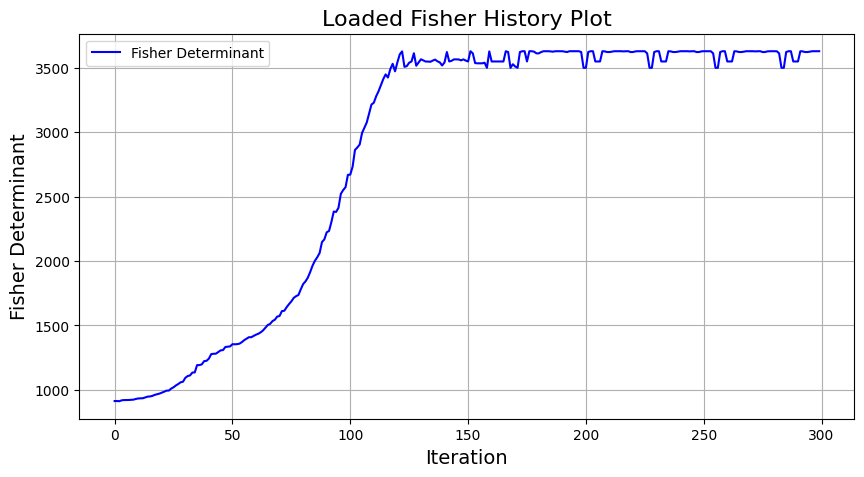

In [48]:
# Load data
iterations = []
fisher_values = []

with open(filename3_fi, "r") as file:
    for line in file:
        data = line.strip().split()  # Split by space
        if len(data) == 2:  # Ensure there are two values (iteration, fisher_value)
            iter_idx, fisher_value = int(data[0]), float(data[1])
            iterations.append(iter_idx)
            fisher_values.append(fisher_value)

# Convert to NumPy array (optional, for easier handling)
iterations = np.array(iterations)
fisher_values = np.array(fisher_values)

# Plot the loaded data
plt.figure(figsize=(10,5))
plt.plot(iterations, fisher_values, color='blue', label="Fisher Determinant")
plt.xlabel("Iteration", fontsize=14)
plt.ylabel("Fisher Determinant", fontsize=14)
plt.title("Loaded Fisher History Plot", fontsize=16)
plt.legend()
plt.grid(True)
plt.show()


### Plot 3 datasets

In [49]:
CFI_10 = f"C:/Users/tvle2/Documents/Code/Bosonic/dataset/fisher_history_10.txt"
CFI_11 = f"C:/Users/tvle2/Documents/Code/Bosonic/dataset/fisher_history_11.txt"
CFI_12 = f"C:/Users/tvle2/Documents/Code/Bosonic/dataset/fisher_history_12.txt"

#####################################
iterations_10 = []
fisher_values_10 = []

with open(CFI_10, "r") as file:
    for line in file:
        data = line.strip().split()  # Split by space
        if len(data) == 2:  # Ensure there are two values (iteration, fisher_value)
            iter_idx, fisher_value = int(data[0]), float(data[1])
            iterations_10.append(iter_idx)
            fisher_values_10.append(fisher_value)

# Convert to NumPy array (optional, for easier handling)
iterations_10 = np.array(iterations_10)
fisher_values_10 = np.array(fisher_values_10)

####################################
iterations_11 = []
fisher_values_11 = []

with open(CFI_11, "r") as file:
    for line in file:
        data = line.strip().split()  # Split by space
        if len(data) == 2:  # Ensure there are two values (iteration, fisher_value)
            iter_idx, fisher_value = int(data[0]), float(data[1])
            iterations_11.append(iter_idx)
            fisher_values_11.append(fisher_value)

# Convert to NumPy array (optional, for easier handling)
iterations_11 = np.array(iterations_11)
fisher_values_11 = np.array(fisher_values_11)

####################################
iterations_12 = []
fisher_values_12 = []

with open(CFI_12, "r") as file:
    for line in file:
        data = line.strip().split()  # Split by space
        if len(data) == 2:  # Ensure there are two values (iteration, fisher_value)
            iter_idx, fisher_value = int(data[0]), float(data[1])
            iterations_12.append(iter_idx)
            fisher_values_12.append(fisher_value)

# Convert to NumPy array (optional, for easier handling)
iterations_12 = np.array(iterations_12)
fisher_values_12 = np.array(fisher_values_12)



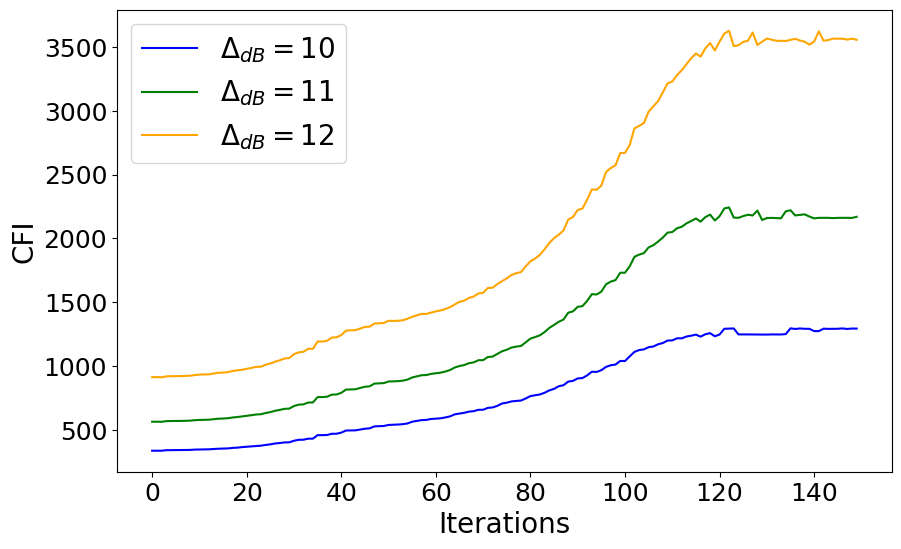

In [15]:
def load_fisher_data(filepath):
    iterations = []
    fisher_values = []
    with open(filepath, "r") as file:
        for line in file:
            data = line.strip().split()  # Split by space
            if len(data) == 2:  # Ensure there are two values (iteration, fisher_value)
                iter_idx, fisher_value = int(data[0]), float(data[1])
                iterations.append(iter_idx)
                fisher_values.append(fisher_value)
    return np.array(iterations), np.array(fisher_values)

# File paths (update these paths as needed)
CFI_10 = "C:/Users/tvle2/Documents/Code/Bosonic/dataset/CFI/fisher_history_10.txt"
CFI_11 = "C:/Users/tvle2/Documents/Code/Bosonic/dataset/CFI/fisher_history_11.txt"
CFI_12 = "C:/Users/tvle2/Documents/Code/Bosonic/dataset/CFI/fisher_history_12.txt"

# Load the data
iterations_10, fisher_values_10 = load_fisher_data(CFI_10)
iterations_11, fisher_values_11 = load_fisher_data(CFI_11)
iterations_12, fisher_values_12 = load_fisher_data(CFI_12)


max_index = 150
iterations_10, fisher_values_10 = iterations_10[:max_index], fisher_values_10[:max_index]
iterations_11, fisher_values_11 = iterations_11[:max_index], fisher_values_11[:max_index]
iterations_12, fisher_values_12 = iterations_12[:max_index], fisher_values_12[:max_index]

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(iterations_10, fisher_values_10,color='blue', label=r"$\Delta_{dB} = 10$")
plt.plot(iterations_11, fisher_values_11,color='green', label=r"$\Delta_{dB} = 11$")
plt.plot(iterations_12, fisher_values_12,color='orange', label=r"$\Delta_{dB} = 12$")


# Optionally increase tick sizes (recommended for clarity)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.xlabel("Iterations", fontsize=20)
plt.ylabel("CFI", fontsize=20)
# plt.title("Comparison of Fisher Values Over Iterations")
plt.legend(fontsize=20)
# plt.grid(True)
plt.show()


In [17]:
import strawberryfields as sf
import numpy as np

# Configuration
sf.hbar = 1
epsilon = 0.1  # Squeezing parameter targeting ~10 photons

def check_gkp_photon_number(epsilon):
    """Verify the average photon number of a GKP state with given epsilon."""
    # Create program with single mode
    prog = sf.Program(1)
    
    # Initialize GKP state
    with prog.context as q:
        sf.ops.GKP(state=[0,0], epsilon=epsilon) | q[0]
    
    # Run simulation with bosonic backend
    eng = sf.Engine("bosonic")
    state = eng.run(prog).state
    
    # Calculate average photon number - extract just the mean from the tuple
    mean_and_var = state.mean_photon(0)
    avg_photon = mean_and_var[0]  # Extract just the mean value
    
    # Print results
    print(f"GKP state with epsilon = {epsilon:.4f}")
    print(f"Average photon number: {avg_photon:.2f}")

    return avg_photon

# Run verification
check_gkp_photon_number(epsilon)


GKP state with epsilon = 0.1000
Average photon number: 4.49


array(4.48707468)